In [1]:
import sas7bdat
from sas7bdat import *
import pandas as pd
import numpy as np
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Flatten, Conv2D, MaxPooling1D,BatchNormalization
from keras.layers import Dropout
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.initializers import *
from keras.optimizers import *
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.utils import resample
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import os
from sklearn.dummy import DummyClassifier
os.environ["KMP_DUPLICATE_LIB_OK"]="True"

Using TensorFlow backend.


In [2]:
#converting sas format data into readable csv using dataframe(ovarian)
foo = SAS7BDAT('OvaryData/ovar_data_feb16_d080516.sas7bdat')
primary_data = foo.to_data_frame()

[ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192
W0723 02:41:24.817127 140585394730752 sas7bdat.py:1335] [ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192


In [3]:
ovarian_data=primary_data

In [4]:
ovarian_data = ovarian_data.reindex(sorted(ovarian_data.columns), axis=1)

In [5]:
#dcf_dthosumm column is silmilar to f_dthosumm(remember death certificate and death review,hence drop the previous)
ovarian_data=ovarian_data.drop(['age','bmi_curr','bq_compdays','breast_fh_age','dcf_dthosumm','sex',
                                'dcf_unddeath',
                                'f_unddeath','build','dcf_cancersite','rsmoker_f',
                                'is_dead','pack_years','dth_days','dth_cat','f_unddeath_ccode','f_codeath_cat',
                                'dcf_codeath_cat','smoked_f','smokea_f','ssmokea_f',
                                'dcf_unddeath_ccode','mortality_exitstat','mortality_exitage',
                                'mortality_exitdays','inci_last_contact_stat','inci_last_contact_days'
                               ,'ovar_exitstat','fstcan_exitstat','cigar',
                               'weight_f','weight20_f','weight50_f','ibup',
                               'menstrs_stat_type','curative_chemoosumm',
                                'curative_surgosumm','osumm_pathstage','confirmed_osumm','ovar_exitage',
                                'ovar_exitdays',
                                'fstcan_exitage','fstcan_exitdays','cstatusosumm_cat','breast_fh_cnt',
                                'mortality_exitdays','f_dthosumm',
                               'osumm_is_first_dx','osumm_stage'
                               ,'reasothosumm','reassymposumm','osumm_histtype','reassurvosumm','reasfollosumm',
                               'osumm_grade'],axis=1)

#column names after the merging

In [6]:
#rename the columns for readability
ovarian_data=ovarian_data.rename(columns={'f_cancersite':'death_ovarian_Cancer','hasdeo0': 'Diagnostic_Evaluation1',
'hasdeo1': 'Diagnostic_Evaluation2','hasdeo2': 'Diagnostic_Evaluation3','hasdeo3': 'Diagnostic_Evaluation4','hasdeo4': 'Diagnostic_Evaluation5',
'hasdeo5': 'Diagnostic_Evaluation6','biopolink0': 'Biopsy1','biopolink1': 'Biopsy2','biopolink2': 'Biopsy3','biopolink3': 'Biopsy4','biopolink4': 'Biopsy5',
'biopolink5': 'Biopsy6','cstatusosumm_cat': 'current_cancer_status',
'confirmed_osumm':'confirmed_ovarian_cancer',
'tvu_result0': 'transvaginal screening1','tvu_result1': 'transvaginal screening2',
'tvu_result2': 'transvaginal screening3','ca125_src0': 'ca125_test_version1',
'ca125_src1': 'ca125_test_version2','ca125_src2': 'ca125_test_version3','ca125_src3': 'ca125_test_version4',
'ca125_src4': 'ca125_test_version5','ca125_src5': 'ca125_test_version6','orem_fyro': 'ovaries_removed(yr/both)'})

In [7]:
def processCancerpriorTrial(columns):
    if(columns[0]==9):
        return -2
    elif(columns[0]==1):
        return 1
    else:
        return 0

In [8]:
ovarian_data['trial_ph_any']=ovarian_data[['trial_ph_any']].apply(processCancerpriorTrial,axis=1)

In [9]:
#columns to fill the NAN value wth -2

columns=['educat','marital','occupat','pipe','sisters','brothers','cig_stat',
        'fmenstr','menstrs','tubal','tuballig','bbd','benign_ovcyst','endometriosis','uterine_fib','mammo_history',
        'papsmear_history','pelvic_history','usound_history','bq_adminm','trypreg','livec',
        'fchilda','hystera','asppd','ibuppd','bcontra','bcontrt','hyperten_f','hearta_f','stroke_f','emphys_f',
        'bronchit_f','diabetes_f','polyps_f','arthrit_f','osteopor_f','divertic_f','gallblad_f','hispanic_f',
        'hyster_f','ovariesr_f','bcontr_f','horm_stat',
        'cigpd_f','filtered_f','cig_stop','cig_years','bmi_20','bmi_50',
        'bmi_curc','ca125_history','post_menopausal',
        'state','colon_comorbidity','liver_comorbidity','fh_cancer','breast_fh','ovarsumm_fh',
        'bq_cohort_entrydays','nrf_reason','nrf_days',
       'breast_fh','tvu_days0','tvu_days1','tvu_days2','tvu_days3','ca125_days0','ca125_days1',
         'ca125_days2','ca125_days3',
         'ca125_days4','ca125_days5','ovaries_removed(yr/both)','ca125_prot',
        'ca125_test_version1','ca125_test_version2','ca125_test_version3','ca125_test_version4','ca125_test_version5'
         ,'ca125_test_version6',
       'transvaginal screening1','transvaginal screening2','transvaginal screening3','tvu_result3','ca125_result0',
         'ca125_result1','ca125_result2','ca125_result3','ca125_result4','ca125_result5',
        'miscar','death_ovarian_Cancer','ca125_level0','ca125_level1',
                                'ca125_level2','ca125_level3','ca125_level4','ca125_level5',
        'ca125ii_level0','ca125ii_level1','ca125ii_level2','ca125ii_level3','ca125ii_level4','ca125ii_level5'
        ,'osumm_pathstage_m','osumm_pathstage_n','osumm_pathstage_t',
                               'osumm_stage_m','osumm_stage_n','osumm_stage_t','primary_trtosumm',
         'primary_trtosumm_days','ovarsumm_fh_cnt','ovarsumm_fh_age','asp','curhorm','horm_f'
        ,'prega','pregc','preg_f','stillb']

In [10]:
ovarian_data[columns]=ovarian_data[columns].fillna(value=-2.0)

In [11]:
def processFamilyBreasthistory(columns):
    if(columns[0]==0 or columns[0]==2):
        return 0
    elif(columns[0]==1 or columns[0]==9):
        return 1

In [12]:
ovarian_data['breast_fh']=ovarian_data[['breast_fh']].apply(processFamilyBreasthistory,axis=1)

In [13]:
def processRace(columns):
    if(columns[0]==7):
        return -2
    return columns[0]

In [14]:
ovarian_data['race7']=ovarian_data[['race7']].apply(processRace,axis=1)

In [15]:
def processFamilyOvarianhistory(columns):
    if(columns[0]==9):
        return 1
    return columns[0]

In [16]:
ovarian_data['ovarsumm_fh']=ovarian_data[['ovarsumm_fh']].apply(processFamilyOvarianhistory,axis=1)

In [17]:
ovarian_data=ovarian_data.rename(columns={'death_ovarian_Cancer':'output'})

In [18]:
#fill NAN with mean values
#ca125ii

columns=['bq_age','bq_cohort_entryage','height_f']
ovarian_data[columns] = ovarian_data[columns].fillna((ovarian_data[columns].mean()))

ovarian_data['thorm'] =ovarian_data['thorm'].fillna(value=0.0) 

In [19]:
pd.set_option('display.max_rows', None)
ovarian_data.isna().sum()

agelevel                        0
arm                             0
arthrit_f                       0
asp                             0
asppd                           0
bbd                             0
bcontr_f                        0
bcontra                         0
bcontrt                         0
benign_ovcyst                   0
Biopsy1                         0
Biopsy2                         0
Biopsy3                         0
Biopsy4                         0
Biopsy5                         0
Biopsy6                         0
bmi_20                          0
bmi_50                          0
bmi_curc                        0
bq_adminm                       0
bq_age                          0
bq_cohort_entryage              0
bq_cohort_entrydays             0
bq_returned                     0
breast_fh                    2612
bronchit_f                      0
brothers                        0
ca125_days0                     0
ca125_days1                     0
ca125_days2   

In [20]:
ovarian_data.fillna(-2,inplace=True)

In [21]:
ovarian_data = ovarian_data[ovarian_data.cancerosumm != 0.0]

In [22]:
ovarian_data['cancerosumm'].value_counts()

1.0    419
2.0     63
3.0     33
4.0     30
5.0      2
6.0      1
Name: cancerosumm, dtype: int64

In [23]:
def processOutput(columns):
    if(columns[0]==-2.0):
        return 0
    elif(columns[0]==4.0):
        return 1
    return columns[0]

In [24]:
ovarian_data['output']=ovarian_data[['output']].apply(processOutput,axis=1)

In [25]:
ovarian_data['output'].value_counts()

1.0     262
0.0     256
99.0      9
98.0      9
18.0      3
11.0      3
15.0      2
14.0      1
16.0      1
20.0      1
23.0      1
Name: output, dtype: int64

In [26]:
ovarian_data = ovarian_data[ovarian_data.output < 2.0]

In [27]:
ovarian_data['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

In [28]:
ovarian_data_new=ovarian_data.dropna()

In [29]:
ovarian_data_new['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

In [30]:
ovarian_data_new=ovarian_data_new.drop('plco_id',axis=1)

In [31]:
dataOutput=pd.DataFrame(ovarian_data_new['output'])

In [32]:
ovarian_data_new=ovarian_data_new.drop(['output'],axis=1)

In [34]:
ovarian_data_new.to_pickle('data') 

In [161]:
trainingData_X, testingData_X, trainingData_Y, testingData_Y = train_test_split(ovarian_data_new,
                                                                                dataOutput,
                                                                                test_size = 0.2)

In [162]:
trainingData_Y['output'].value_counts()

0.0    208
1.0    206
Name: output, dtype: int64

In [163]:
testingData_Y['output'].value_counts()

1.0    56
0.0    48
Name: output, dtype: int64

In [164]:
trainingData_X = trainingData_X.drop(['output'],axis=1)
testingData_X = testingData_X.drop(['output'],axis=1)
ovarian_data_new=ovarian_data_new.drop(['output'],axis=1)

In [165]:
scaler = pre.MinMaxScaler(feature_range=(0,1))
intermediate=scaler.fit(ovarian_data_new.values)

In [166]:
x_train=trainingData_X.values
x_train=intermediate.transform(x_train)

In [167]:
x_test=testingData_X.values
x_test=intermediate.transform(x_test)

In [168]:
y_train=trainingData_Y.values
y_test=testingData_Y.values

In [169]:
len(y_train)

414

In [170]:
y_train.shape

(414, 1)

In [171]:
smt=SMOTE()
X_new=np.concatenate((x_train,y_train),axis=1)

not_dead=X_new[X_new[:,-1]==0]
dead=X_new[X_new[:,-1]==1]

not_dead_new=resample(not_dead,replace=True,n_samples=2000,random_state=123)
dead_new=resample(dead,replace=True,n_samples=2000,random_state=123)

x_train_new=np.concatenate((not_dead_new,dead),axis=0)
y_train_new=x_train_new[:,-1]
x_train_new=x_train_new[:,:-1]

x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)
y_train_new=y_train_new.reshape(y_train_new.shape[0],1)
X_new=np.concatenate((x_train_new,y_train_new),axis=1)
dead=X_new[X_new[:,-1]==1]

x_train_new=np.concatenate((not_dead,dead),axis=0)
y_train_new=x_train_new[:,-1]
x_train_new=x_train_new[:,:-1]
x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)

x_train=x_train_new
y_train=y_train_new

In [172]:
x_train=x_train.reshape(x_train.shape[0],x_test.shape[1],1).astype('float32')
y_train=y_train.astype('float32')

x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype('float32')
y_test=y_test.astype('float32')

In [173]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [174]:
y_train.shape

(4000, 2)

In [175]:
np.save('x_train.npy',x_train)
np.save('x_test.npy',x_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)

In [111]:
def apply_smote(X_Train,Y_Train):
    
    smt=SMOTE()
    X_new=np.concatenate((X_Train,Y_Train),axis=1)

    not_dead=X_new[X_new[:,-1]==0]
    dead=X_new[X_new[:,-1]==1]

    not_dead_new=resample(not_dead,replace=True,n_samples=2000,random_state=123)
    dead_new=resample(dead,replace=True,n_samples=2000,random_state=123)

    x_train_new=np.concatenate((not_dead_new,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]

    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)
    y_train_new=y_train_new.reshape(y_train_new.shape[0],1)
    X_new=np.concatenate((x_train_new,y_train_new),axis=1)
    dead=X_new[X_new[:,-1]==1]

    x_train_new=np.concatenate((not_dead,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]
    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)

    x_train=x_train_new
    y_train=y_train_new
    

    x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype('float32')
    

    return x_train,y_train
    

...........................10 FOLD CROSS VALIDATION ON CONCENSUS MODEL...............................

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 1 started
Model 1 trained
53/53 [==============================] - 0s 202us/step
Accuracy of the Model 1:Fold Number1 is: 69.81% 
Precision of the Model is: 70.37
Recall of the Model is: 70.37 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         19         8
True: No           8        18
Model 2 trained
53/53 [==============================] - 0s 181us/step
Accuracy of the Model 2:Fold Number1 is: 73.58% 
Precision of the Model is: 0.76
Recall of the Model is: 0.70 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         19         8
True: No           6        20
Model 3 trained
53/53 [==============================] - 0s 147us/step
Accuracy of the Model 3:Fold Number1 is: 67.92% 
Precision of the Model is: 0.73
Recall of the Model is: 0.59 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         16        

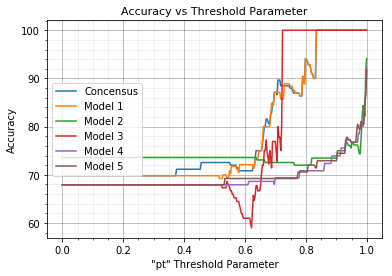

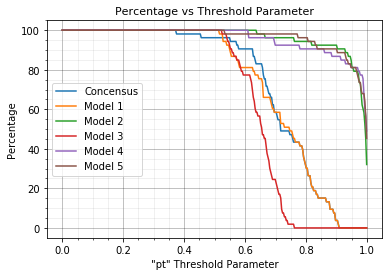

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 2 started
Model 1 trained
53/53 [==============================] - 0s 173us/step
Accuracy of the Model 1:Fold Number2 is: 62.26% 
Precision of the Model is: 60.61
Recall of the Model is: 74.07 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         20         7
True: No          13        13
Model 2 trained
53/53 [==============================] - 0s 170us/step
Accuracy of the Model 2:Fold Number2 is: 67.92% 
Precision of the Model is: 0.71
Recall of the Model is: 0.63 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         17        10
True: No           7        19
Model 3 trained
53/53 [==============================] - 0s 189us/step
Accuracy of the Model 3:Fold Number2 is: 69.81% 
Precision of the Model is: 0.70
Recall of the Model is: 0.70 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         19        

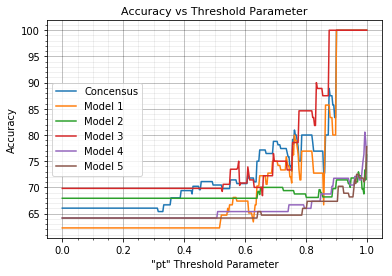

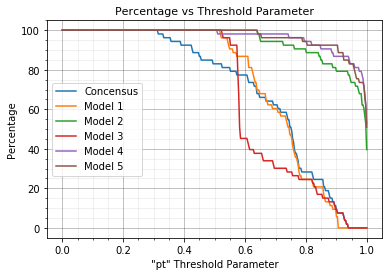

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 3 started
Epoch 00131: early stopping
Model 1 trained
52/52 [==============================] - 0s 160us/step
Accuracy of the Model 1:Fold Number3 is: 73.08% 
Precision of the Model is: 75.00
Recall of the Model is: 69.23 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         18         8
True: No           6        20
Model 2 trained
52/52 [==============================] - 0s 202us/step
Accuracy of the Model 2:Fold Number3 is: 61.54% 
Precision of the Model is: 0.62
Recall of the Model is: 0.58 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         15        11
True: No           9        17
Model 3 trained
52/52 [==============================] - 0s 184us/step
Accuracy of the Model 3:Fold Number3 is: 73.08% 
Precision of the Model is: 0.75
Recall of the Model is: 0.69 

The confusion Matrix is:

           Pred: Yes  Pred: No


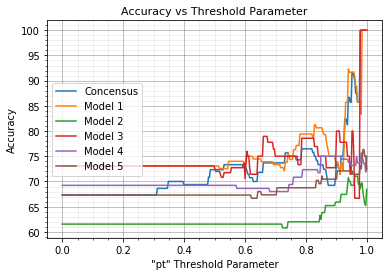

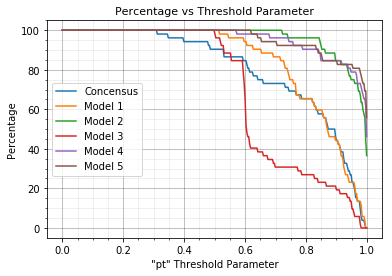

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 4 started
Model 1 trained
52/52 [==============================] - 0s 214us/step
Accuracy of the Model 1:Fold Number4 is: 80.77% 
Precision of the Model is: 76.67
Recall of the Model is: 88.46 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         23         3
True: No           7        19
Epoch 00136: early stopping
Model 2 trained
52/52 [==============================] - 0s 196us/step
Accuracy of the Model 2:Fold Number4 is: 69.23% 
Precision of the Model is: 0.73
Recall of the Model is: 0.62 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         16        10
True: No           6        20
Model 3 trained
52/52 [==============================] - 0s 220us/step
Accuracy of the Model 3:Fold Number4 is: 84.62% 
Precision of the Model is: 0.88
Recall of the Model is: 0.81 

The confusion Matrix is:

           Pred: Yes  Pred: No


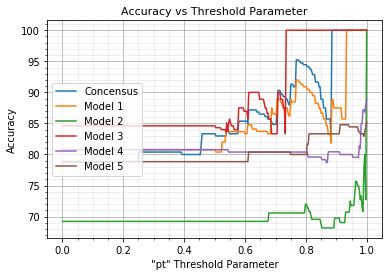

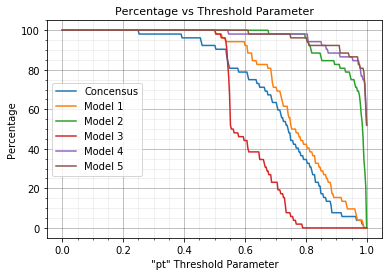

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 5 started
Epoch 00149: early stopping
Model 1 trained
52/52 [==============================] - 0s 182us/step
Accuracy of the Model 1:Fold Number5 is: 73.08% 
Precision of the Model is: 77.27
Recall of the Model is: 65.38 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         17         9
True: No           5        21
Model 2 trained
52/52 [==============================] - 0s 217us/step
Accuracy of the Model 2:Fold Number5 is: 67.31% 
Precision of the Model is: 0.68
Recall of the Model is: 0.65 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         17         9
True: No           8        18
Model 3 trained
52/52 [==============================] - 0s 164us/step
Accuracy of the Model 3:Fold Number5 is: 78.85% 
Precision of the Model is: 0.86
Recall of the Model is: 0.69 

The confusion Matrix is:

           Pred: Yes  Pred: No


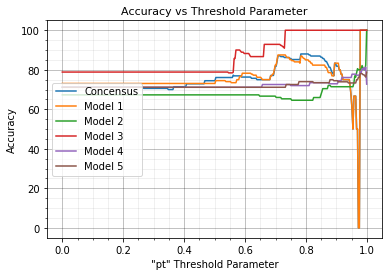

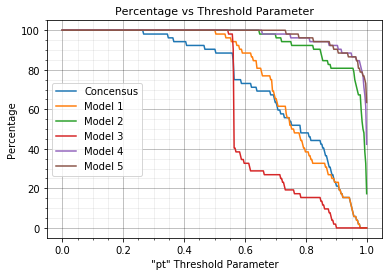

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 6 started
Epoch 00108: early stopping
Model 1 trained
52/52 [==============================] - 0s 313us/step
Accuracy of the Model 1:Fold Number6 is: 67.31% 
Precision of the Model is: 73.68
Recall of the Model is: 53.85 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         14        12
True: No           5        21
Model 2 trained
52/52 [==============================] - 0s 351us/step
Accuracy of the Model 2:Fold Number6 is: 75.00% 
Precision of the Model is: 0.78
Recall of the Model is: 0.69 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         18         8
True: No           5        21
Model 3 trained
52/52 [==============================] - 0s 182us/step
Accuracy of the Model 3:Fold Number6 is: 69.23% 
Precision of the Model is: 0.75
Recall of the Model is: 0.58 

The confusion Matrix is:

           Pred: Yes  Pred: No


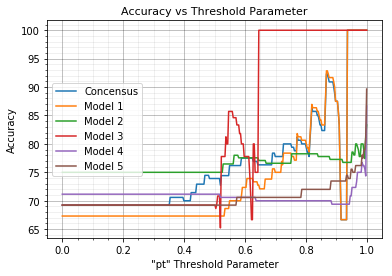

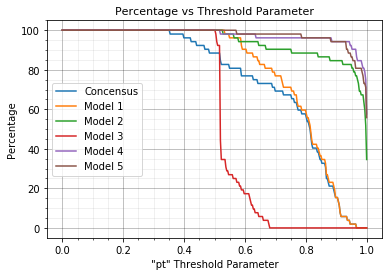

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 7 started
Model 1 trained
51/51 [==============================] - 0s 217us/step
Accuracy of the Model 1:Fold Number7 is: 70.59% 
Precision of the Model is: 68.97
Recall of the Model is: 76.92 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         20         6
True: No           9        16
Epoch 00133: early stopping
Model 2 trained
51/51 [==============================] - 0s 183us/step
Accuracy of the Model 2:Fold Number7 is: 62.75% 
Precision of the Model is: 0.65
Recall of the Model is: 0.58 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         15        11
True: No           8        17
Model 3 trained
51/51 [==============================] - 0s 264us/step
Accuracy of the Model 3:Fold Number7 is: 64.71% 
Precision of the Model is: 0.65
Recall of the Model is: 0.65 

The confusion Matrix is:

           Pred: Yes  Pred: No


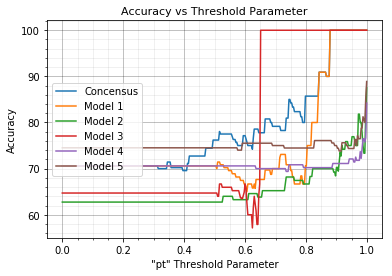

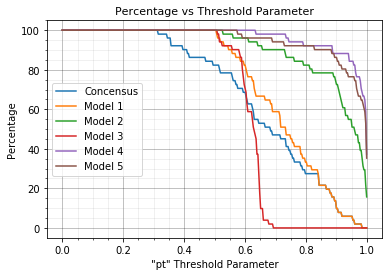

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 8 started
Model 1 trained
51/51 [==============================] - 0s 399us/step
Accuracy of the Model 1:Fold Number8 is: 74.51% 
Precision of the Model is: 78.26
Recall of the Model is: 69.23 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         18         8
True: No           5        20
Model 2 trained
51/51 [==============================] - 0s 153us/step
Accuracy of the Model 2:Fold Number8 is: 72.55% 
Precision of the Model is: 0.73
Recall of the Model is: 0.73 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         19         7
True: No           7        18
Model 3 trained
51/51 [==============================] - 0s 156us/step
Accuracy of the Model 3:Fold Number8 is: 72.55% 
Precision of the Model is: 0.71
Recall of the Model is: 0.77 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         20        

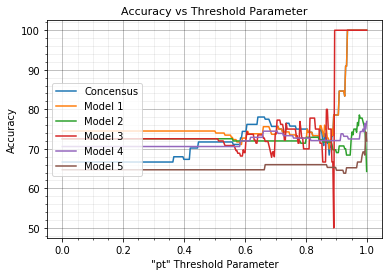

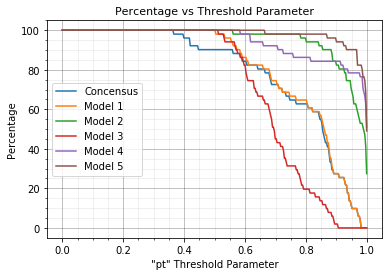

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 9 started
Model 1 trained
51/51 [==============================] - 0s 166us/step
Accuracy of the Model 1:Fold Number9 is: 60.78% 
Precision of the Model is: 63.64
Recall of the Model is: 53.85 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         14        12
True: No           8        17
Epoch 00130: early stopping
Model 2 trained
51/51 [==============================] - 0s 162us/step
Accuracy of the Model 2:Fold Number9 is: 64.71% 
Precision of the Model is: 0.65
Recall of the Model is: 0.65 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         17         9
True: No           9        16
Model 3 trained
51/51 [==============================] - 0s 169us/step
Accuracy of the Model 3:Fold Number9 is: 66.67% 
Precision of the Model is: 0.71
Recall of the Model is: 0.58 

The confusion Matrix is:

           Pred: Yes  Pred: No


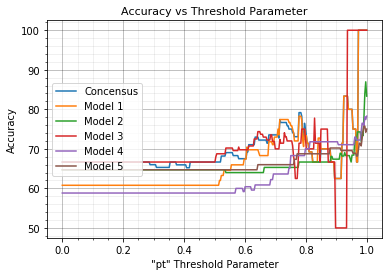

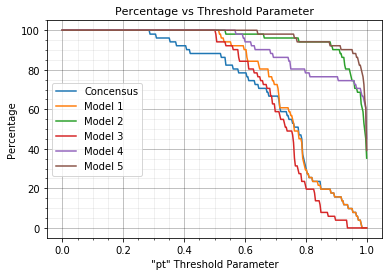

This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients

The iteration 10 started
Model 1 trained
51/51 [==============================] - 0s 153us/step
Accuracy of the Model 1:Fold Number10 is: 78.43% 
Precision of the Model is: 75.86
Recall of the Model is: 84.62 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         22         4
True: No           7        18
Model 2 trained
51/51 [==============================] - 0s 140us/step
Accuracy of the Model 2:Fold Number10 is: 84.31% 
Precision of the Model is: 0.80
Recall of the Model is: 0.92 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         24         2
True: No           6        19
Model 3 trained
51/51 [==============================] - 0s 162us/step
Accuracy of the Model 3:Fold Number10 is: 82.35% 
Precision of the Model is: 0.76
Recall of the Model is: 0.96 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         25    

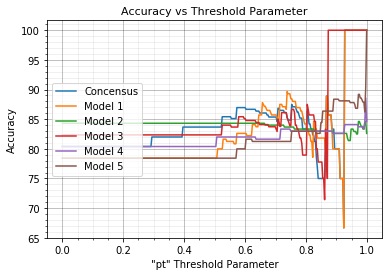

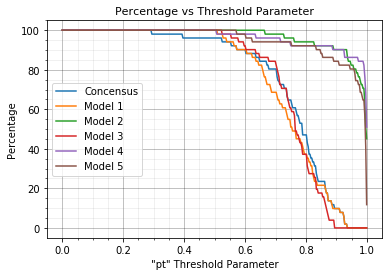

In [114]:
K.clear_session()
from sklearn.model_selection import KFold,StratifiedKFold
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

X = ovarian_data_new.values
X = X.astype('float32')
intermediate = scaler.fit(X)
X = intermediate.transform(X)


Y = dataOutput.values
Y = Y.astype('float32')


ptList=np.arange(0,1,0.003)
accuracyList=[]
percentList=[]


iteration=1
k=4
scoreList=[]
predictionList=[]
y_testList=[]

for train_index, test_index in kf.split(X,Y):
    
    
    print("This is the entire Training for the 10 fold concensus model for mortality of ovarian cancer patients\n")
    print("The iteration",iteration,"started")
    
    
    
    AccuracyOfEachFold=[]
    ClassPrediction=[]
    
    X_Train = X[train_index]
    X_Test = X[test_index]

    Y_Train = Y[train_index]
    Y_Test = Y[test_index]
    
    x_train, y_train = apply_smote(X_Train,Y_Train)
    
    x_test=X_Test.reshape(X_Test.shape[0],X_Test.shape[1],1).astype('float32')
    y_test=Y_Test


    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
  #------------------------------------MODEL'S TRAINING STARTS HERE----------------------------------------------#  
    
    
    #--------------------------------------------------------------------------------------------------------#

                   #---------------------------MODEL -1 ------------------------------#
    
    if(os.path.isfile("Model 1:Fold Number"+str(iteration)+".h5")):
        model1 = load_model("Model 1:Fold Number"+str(iteration)+".h5")
        print("Model 1 using the saved model") 
        
    else:
            
        model1=Sequential()
        model1.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                                     kernel_initializer='lecun_normal')))
        model1.add(MaxPooling1D(2))
        model1.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='lecun_normal',
                                      kernel_regularizer=regularizers.l2(0.01))))
        model1.add(MaxPooling1D(2))
        model1.add((LocallyConnected1D(4, 4,activation='selu',kernel_initializer='lecun_normal'
                                      ,kernel_regularizer=regularizers.l2(0.01))))
        model1.add(MaxPooling1D(2))

        model1.add(Flatten())
        model1.add(Dense(128,activation='elu',kernel_regularizer=regularizers.l2(0.01)))
        model1.add(Dropout(0.2))
        model1.add(Dense(64,activation='elu',kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(0.01)))
        model1.add(Dropout(0.2))
        model1.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform'))
        model1.add(Dropout(0.2))
        model1.add(Dense(16,activation='selu',kernel_initializer='lecun_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model1.add(Dropout(0.2))
        model1.add(Dense(8,activation='relu',kernel_initializer='glorot_uniform'))
        model1.add(Dropout(0.2))
        model1.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

        model1.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.00001),metrics=['accuracy'])

        #model1.summary()

        es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

        history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=32, epochs=150,verbose=0,callbacks=[es1])

        model1.save("Model 1:Fold Number"+str(iteration)+".h5")
        
    print("Model 1 trained")

    predict1=model1.predict(x_test)
    scores = model1.evaluate(x_test, y_test)
    print("Accuracy of the Model 1:Fold Number"+str(iteration)+" is: %.2f%% " % (scores[1]*100))


    conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict1,axis=1),labels=[1,0])
    print("Precision of the Model is: %.2f"% ((conf[0][0]/(conf[0][0]+conf[1][0]))*100))
    print("Recall of the Model is: %.2f \n"% ((conf[0][0]/(conf[0][0]+conf[0][1]))*100))
    print("The confusion Matrix is:\n")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))
   
    AccuracyOfEachFold.append(scores[1]*100)
    ClassPrediction.append(predict1)
    
    K.clear_session()
    
    
    
#-----------------------------------------------------------------------------------------------------------------#

                   #---------------------------MODEL -2 ------------------------------#
    
    
    if(os.path.isfile("Model 2:Fold Number"+str(iteration)+".h5")):
        model2 = load_model("Model 2:Fold Number"+str(iteration)+".h5")
        print("Model 2 using the saved model") 
        
    else:
        
        model2=Sequential()
        model2.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                                     kernel_initializer='lecun_normal')))
        model2.add(MaxPooling1D(2))
        model2.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='lecun_normal',
                                      kernel_regularizer=regularizers.l2(0.01))))
        model2.add(MaxPooling1D(2))
        model2.add((LocallyConnected1D(4, 4,activation='selu',kernel_initializer='lecun_normal'
                                      ,kernel_regularizer=regularizers.l2(0.01))))
        model2.add(MaxPooling1D(2))

        model2.add(Flatten())
        model2.add(Dense(128,activation='elu',kernel_regularizer=regularizers.l2(0.01)))
        model2.add(Dropout(0.2))
        model2.add(Dense(64,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
        model2.add(Dropout(0.2))
        model2.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform'))
        model2.add(Dropout(0.2))
        model2.add(Dense(16,activation='selu',kernel_initializer='lecun_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model2.add(Dropout(0.2))
        model2.add(Dense(8,activation='relu',kernel_initializer='glorot_uniform'))
        model2.add(Dropout(0.2))
        model2.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))


        model2.compile(loss='categorical_hinge', optimizer=Adam(lr=0.00001),metrics=['accuracy'])

        #model2.summary()

        es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

        history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=32, epochs=150,verbose=0,callbacks=[es2])

        model2.save("Model 2:Fold Number"+str(iteration)+".h5")
        
    print("Model 2 trained")

    predict2 = model2.predict(x_test)
    scores = model2.evaluate(x_test, y_test)

    print("Accuracy of the Model 2:Fold Number"+str(iteration)+" is: %.2f%% " % (scores[1]*100))

    conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict2,axis=1),labels=[1,0])
    print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
    print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
    print("The confusion Matrix is:\n")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))
   
    AccuracyOfEachFold.append(scores[1]*100)
    ClassPrediction.append(predict2)
    
    K.clear_session()
    
    
    #---------------------------------------------------------------------------------------------------------#

                   #---------------------------MODEL -3 ------------------------------#
        
        
        
        
    if(os.path.isfile("Model 3:Fold Number"+str(iteration)+".h5")):
        model3 = load_model("Model 3:Fold Number"+str(iteration)+".h5")
        print("Model 3 using the saved model") 
        
    else:
        
        model3=Sequential()
        model3.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                                     kernel_initializer='lecun_normal')))
        model3.add(MaxPooling1D(2))
        model3.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                                      kernel_regularizer=regularizers.l2(0.01))))
        model3.add(MaxPooling1D(2))
        model3.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='lecun_normal'
                                      ,kernel_regularizer=regularizers.l2(0.01))))
        model3.add(MaxPooling1D(2))

        model3.add(Flatten())


        model3.add(Dense(128,activation='elu',kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(0.01)))
        model3.add(Dropout(0.2))
        model3.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
        model3.add(Dropout(0.2))
        model3.add(Dense(32,activation='elu',kernel_initializer='lecun_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model3.add(Dropout(0.2))
        model3.add(Dense(16,activation='tanh',kernel_initializer='he_uniform'))
        model3.add(Dropout(0.2))
        model3.add(Dense(8,activation='relu',kernel_initializer='lecun_uniform'))
        model3.add(Dropout(0.2))
        model3.add(Dense(4,activation='relu',kernel_initializer='he_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model3.add(Dropout(0.2))

        model3.add(Dense(2, activation='softmax',kernel_initializer='glorot_normal'))

        model3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001),metrics=['accuracy'])
        #model3.summary()

        es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

        history3 = model3.fit(x_train, y_train,validation_data=(x_test, y_test), batch_size=32, epochs=150,verbose=0,callbacks=[es3])

        model3.save("Model 3:Fold Number"+str(iteration)+".h5")
        
    print("Model 3 trained")

    predict3 = model3.predict(x_test)
    scores = model3.evaluate(x_test, y_test)

    print("Accuracy of the Model 3:Fold Number"+str(iteration)+" is: %.2f%% " % (scores[1]*100))

    conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict3,axis=1),labels=[1,0])
    print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
    print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
    print("The confusion Matrix is:\n")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

    AccuracyOfEachFold.append(scores[1]*100)
    ClassPrediction.append(predict3)
    
    K.clear_session()
    
        
    #------------------------------------------------------------------------------------------------------------#

                   #---------------------------MODEL -4 ------------------------------#
        
        
    if(os.path.isfile("Model 4:Fold Number"+str(iteration)+".h5")):
        model4 = load_model("Model 4:Fold Number"+str(iteration)+".h5")
        print("Model 4 using the saved model") 
        
    else:
        
        model4=Sequential()
        model4.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                                     kernel_initializer='he_normal')))
        model4.add(MaxPooling1D(2))
        model4.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                                      kernel_regularizer=regularizers.l2(0.01))))
        model4.add(MaxPooling1D(2))
        model4.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='he_normal'
                                      ,kernel_regularizer=regularizers.l2(0.01))))
        model4.add(MaxPooling1D(4))

        model4.add(Flatten())


        model4.add(Dense(128,activation='elu',kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(0.01)))
        model4.add(Dropout(0.2))
        model4.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
        model4.add(Dropout(0.2))
        model4.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))

        model4.add(Dense(16,activation='tanh',kernel_initializer='lecun_uniform'))
        model4.add(Dropout(0.2))
        model4.add(Dense(8,activation='elu',kernel_initializer='glorot_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model4.add(Dropout(0.2))

        model4.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

        model4.compile(loss='categorical_hinge', optimizer=Adam(lr=0.000015),metrics=['accuracy'])
        #model4.summary()

        es4 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

        history4 = model4.fit(x_train, y_train,validation_data=(x_test, y_test), batch_size=32, epochs=150,verbose=0,callbacks=[es4])

        model4.save("Model 4:Fold Number"+str(iteration)+".h5")
        
    print("Model 4 trained")

    predict4 = model4.predict(x_test)
    scores = model4.evaluate(x_test, y_test)

    print("Accuracy of the Model 4:Fold Number"+str(iteration)+" is: %.2f%% " % (scores[1]*100))

    conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict4,axis=1),labels=[1,0])
    print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
    print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
    print("The confusion Matrix is:\n")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))


    AccuracyOfEachFold.append(scores[1]*100)
    ClassPrediction.append(predict4)
    
    K.clear_session()    
    
    
    
    #-----------------------------------------------------------------------------------------------------------#

                   #---------------------------MODEL -5 ------------------------------#
        
    
    if(os.path.isfile("Model 5:Fold Number"+str(iteration)+".h5")):
        model5 = load_model("Model 5:Fold Number"+str(iteration)+".h5")
        print("Model 5 using the saved model") 
        
    else:
        
        model5=Sequential()
        model5.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                                     kernel_initializer='he_normal')))
        model5.add(MaxPooling1D(2))
        model5.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                                      kernel_regularizer=regularizers.l2(0.01))))
        model5.add(MaxPooling1D(2))
        model5.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='he_normal'
                                      ,kernel_regularizer=regularizers.l2(0.01))))
        model5.add(MaxPooling1D(2))

        model5.add(Flatten())


        model5.add(Dense(128,activation='elu',kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(0.01)))
        model5.add(Dropout(0.2))
        model5.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
        model5.add(Dropout(0.2))
        model5.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))

        model5.add(Dense(16,activation='elu',kernel_initializer='lecun_uniform'))
        model5.add(Dropout(0.2))
        model5.add(Dense(8,activation='elu',kernel_initializer='glorot_uniform',
                         kernel_regularizer=regularizers.l2(0.01)))
        model5.add(Dropout(0.2))

        model5.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

        model5.compile(loss='categorical_hinge', optimizer=Adam(lr=0.000015),metrics=['accuracy'])

        #model5.summary()

        es5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

        history5 = model5.fit(x_train, y_train,validation_data=(x_test, y_test), batch_size=32, epochs=150,verbose=0,callbacks=[es5])

        model5.save("Model 5:Fold Number"+str(iteration)+".h5")
        
    print("Model 5 trained")

    predict5 = model5.predict(x_test)
    scores = model5.evaluate(x_test, y_test)

    print("Accuracy of the Model 5:Fold Number"+str(iteration)+" is: %.2f%% " % (scores[1]*100))

    conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict5,axis=1),labels=[1,0])
    print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
    print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
    print("The confusion Matrix is:\n")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))


    AccuracyOfEachFold.append(scores[1]*100)
    ClassPrediction.append(predict5)
    
    K.clear_session()    
        
    
    
    accuracy=[[0],[0],[0],[0],[0],[0]]
    percent=[[0],[0],[0],[0],[0],[0]]

    for pt in ptList:
        
        it=0
        predictionListofDict = [dict() for x in range(6)]


        naminglist=['Concensus','Model1','Model2','Model3','Model4','Model5']

        for itera,names in zip(predictionListofDict,naminglist):
            itera[names] = [{'0':[]},{'1':[]}]

    

        for p1,p2,p3,p4,p5 in zip(predict1,predict2,predict3,predict4,predict5):

            zeroProb = [p1[0],p2[0],p3[0],p4[0],p5[0]]
            oneProb = [p1[1],p2[1],p3[1],p4[1],p5[1]]

            zeroProb.sort(reverse=True)
            oneProb.sort(reverse=True)

            if(zeroProb[k-1]>oneProb[k-1]):
                if(zeroProb[k-1]>pt):
                    predictionListofDict[0]['Concensus'][0]['0'].append(it)

            else:
                if(oneProb[k-1]>pt):
                    predictionListofDict[0]['Concensus'][1]['1'].append(it)


            if(p1[0]>p1[1]):
                if(p1[0]>pt):
                    predictionListofDict[1]['Model1'][0]['0'].append(it)
            else:
                if(p1[1]>pt):
                    predictionListofDict[1]['Model1'][1]['1'].append(it)

            if(p2[0]>p2[1]):
                if(p2[0]>pt):
                    predictionListofDict[2]['Model2'][0]['0'].append(it)
            else:
                if(p2[1]>pt):
                    predictionListofDict[2]['Model2'][1]['1'].append(it)

            if(p3[0]>p3[1]):
                if(p3[0]>pt):
                    predictionListofDict[3]['Model3'][0]['0'].append(it)
            else:
                if(p3[1]>pt):
                    predictionListofDict[3]['Model3'][1]['1'].append(it)

            if(p4[0]>p4[1]):
                if(p4[0]>pt):
                    predictionListofDict[4]['Model4'][0]['0'].append(it)
            else:
                if(p4[1]>pt):
                    predictionListofDict[4]['Model4'][1]['1'].append(it)

            if(p5[0]>p5[1]):
                if(p5[0]>pt):
                    predictionListofDict[5]['Model5'][0]['0'].append(it)
            else:
                if(p5[1]>pt):
                    predictionListofDict[5]['Model5'][1]['1'].append(it)

            it+=1


        correct=0
        incorrect=0

        for values in predictionListofDict[0]['Concensus'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[0]['Concensus'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1 

        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100


        accuracy[0].append(acc)
        percent[0].append(per)

        correct=0
        incorrect=0
        for values in predictionListofDict[1]['Model1'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[1]['Model1'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1

        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100



        accuracy[1].append(acc)
        percent[1].append(per)


        correct=0
        incorrect=0
        for values in predictionListofDict[2]['Model2'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[2]['Model2'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1

        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100



        accuracy[2].append(acc)
        percent[2].append(per)

        correct=0
        incorrect=0


        for values in predictionListofDict[3]['Model3'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[3]['Model3'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1

        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100



        accuracy[3].append(acc)
        percent[3].append(per)


        correct=0
        incorrect=0

        for values in predictionListofDict[4]['Model4'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[4]['Model4'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1


        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100



        accuracy[4].append(acc)
        percent[4].append(per)

        correct=0
        incorrect=0
        for values in predictionListofDict[5]['Model5'][0]['0']:
            if np.argmax(y_test[values]) ==0:
                correct = correct+1
            else:
                incorrect = incorrect+1

        for values in predictionListofDict[5]['Model5'][1]['1']:
            if np.argmax(y_test[values]) ==1:
                correct = correct+1
            else:
                incorrect = incorrect+1


        acc=100
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100




        accuracy[5].append(acc)
        percent[5].append(per)

    for i in range(6):
        accuracy[i].pop(0)
        percent[i].pop(0)

    #figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(ptList,accuracy[0])
    plt.plot(ptList,accuracy[1])
    plt.plot(ptList,accuracy[2])
    plt.plot(ptList,accuracy[3])
    plt.plot(ptList,accuracy[4])
    plt.plot(ptList,accuracy[5])

    plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
    plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
    plt.minorticks_on()
    plt.title('Accuracy vs Threshold Parameter',fontsize=11)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('"pt" Threshold Parameter',fontsize=10)
    plt.legend(['Concensus', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='center left')
    plt.savefig('accuracyPlot.png',prop={'size': 8})
    plt.show()

    #figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(ptList,percent[0])
    plt.plot(ptList,percent[1])
    plt.plot(ptList,percent[2])
    plt.plot(ptList,percent[3])
    plt.plot(ptList,percent[4])
    plt.plot(ptList,percent[5])

    plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
    plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
    plt.minorticks_on()
    plt.title('Percentage vs Threshold Parameter',fontsize=11)
    plt.ylabel('Percentage',fontsize=10)
    plt.xlabel('"pt" Threshold Parameter',fontsize=10)
    plt.legend(['Concensus', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='center left')
    plt.savefig('percentPlot.png',prop={'size': 8})
    plt.show()
    
    
    iteration+=1
    
    scoreList.append(AccuracyOfEachFold)
    predictionList.append(ClassPrediction)
    y_testList.append(y_test)
    
np.save('AccuracyOfAllFolds.npy',np.array(scoreList))
np.save('predictionOfAllFolds.npy',np.array(predictionList))
np.save('y_testAll.npy',np.array(y_testList))    

In [115]:
print("The average accuracy of each model:\n")
for i in range(5):
    print("\tModel",(i+1), " - %.2f%% (+/- %.2f%%)" % (np.mean(scoreList[i]), np.std(scoreList[i])))
    print()

The average accuracy of each model:

	Model 1  - 69.43% (+/- 2.20%)

	Model 2  - 65.66% (+/- 2.77%)

	Model 3  - 68.85% (+/- 4.28%)

	Model 4  - 78.85% (+/- 5.16%)

	Model 5  - 72.31% (+/- 3.77%)



In [119]:
ptListNew=[0.5,0.51,0.525,0.55,0.56,0.57,0.5625,0,5275]
k=4

for pt in ptListNew:
    accuracyList=[[0],[0],[0],[0],[0],[0]]
    percentList=[[0],[0],[0],[0],[0],[0]]

    precisionList=[[0],[0],[0],[0],[0],[0]]
    recallList=[[0],[0],[0],[0],[0],[0]]
    
    for prediction, y_test in zip(predictionList,y_testList):
        
        prediction1=prediction[0]
        prediction2=prediction[1]
        prediction3=prediction[2]
        prediction4=prediction[3]
        prediction5=prediction[4]
        prediction=[[0],[0],[0],[0],[0],[0]]
        predictionProb=[[0],[0],[0],[0],[0],[0]]

        it=0


        for p1,p2,p3,p4,p5 in zip(prediction1,prediction2,prediction3,prediction4,prediction5):

            zeroProb=[p1[0],p2[0],p3[0],p4[0],p5[0]]
            oneProb=[p1[1],p2[1],p3[1],p4[1],p5[1]]
            zeroProb.sort(reverse=True)
            oneProb.sort(reverse=True)

            if(zeroProb[k-1]>oneProb[k-1]):
                if(zeroProb[k-1]>pt):
                    prediction[0].append([it,0])
                    predictionProb[0].append(np.average(oneProb[:k-1]))
            else:
                if(oneProb[k-1]>pt):
                    prediction[0].append([it,1])
                    predictionProb[0].append(np.average(oneProb[:k-1]))

            if(p1[0]>p1[1]):
                if(p1[0]>pt):
                    prediction[1].append([it,0])
                    predictionProb[1].append(p1[1])
            else:
                if(p1[1]>pt):
                    prediction[1].append([it,1])
                    predictionProb[1].append(p1[1])

            if(p2[0]>p2[1]):
                if(p2[0]>pt):
                    prediction[2].append([it,0])
                    predictionProb[2].append(p2[1])
            else:
                if(p2[1]>pt):
                    prediction[2].append([it,1])
                    predictionProb[2].append(p2[1])

            if(p3[0]>p3[1]):
                if(p3[0]>pt):
                    prediction[3].append([it,0])
                    predictionProb[3].append(p3[1])
            else:
                if(p3[1]>pt):
                    prediction[3].append([it,1])
                    predictionProb[3].append(p3[1])

            if(p4[0]>p4[1]):
                if(p4[0]>pt):
                    prediction[4].append([it,0])
                    predictionProb[4].append(p4[1])
            else:
                if(p4[1]>pt):
                    prediction[4].append([it,1])
                    predictionProb[4].append(p4[1])

            if(p5[0]>p5[1]):
                if(p5[0]>pt):
                    prediction[5].append([it,0])
                    predictionProb[5].append(p5[1])
            else:
                if(p5[1]>pt):
                    prediction[5].append([it,1])
                    predictionProb[5].append(p5[1])

            it+=1

        for i in range(6):
            prediction[i].pop(0)
            predictionProb[i].pop(0)

        for i in range(6):
            correct=0
            incorrect=0
            y_test_new=[]
            y_pred_new=[]
            y_pred_prob_new=[]
            for p,pp in zip(prediction[i],predictionProb[i]):
                y_test_new.append(np.argmax(y_test[p[0]]))
                y_pred_new.append(p[1])
                y_pred_prob_new.append(pp)
                if(p[1]==np.argmax(y_test[p[0]])):
                    correct+=1
                else:
                    incorrect+=1
            acc=0
            if(correct+incorrect>0):
                acc=(correct/(incorrect+correct))*100
            per=((correct+incorrect)/y_test.shape[0])*100

            accuracyList[i].append(acc)
            percentList[i].append(per)

            conf=confusion_matrix(y_test_new,y_pred_new,labels=[1,0])
            precision=(conf[0][0]/(conf[0][0]+conf[1][0]))*100
            recall=(conf[0][0]/(conf[0][0]+conf[0][1]))*100
            precisionList[i].append(precision)
            recallList[i].append(recall)

    for i in range(6):
        precisionList[i].pop(0)
        recallList[i].pop(0)
        accuracyList[i].pop(0)
        percentList[i].pop(0)
    
    print("\n\nThe threshold selected for the results is: %.2f%%"% (pt*100))
    for i in range(6):
        if i==0:
            print("The Accuracy of Concensus of the models is: %.2f%% (+/- %.2f%%)"
                  % (np.mean(accuracyList[i]), np.std(accuracyList[i]))
                  ,"for %.2f%% (+/- %.2f%%)"
                  % (np.mean(percentList[i]), np.std(percentList[i]))
                  ,"precent of data")
            
            print("The Precsion of Concensus of the models is: %.2f%% (+/- %.2f%%)"
                  % (np.mean(precisionList[i]), np.std(precisionList[i])))
            
            print("The Recall of Concensus of the models is: %.2f%% (+/- %.2f%%)\n"
                  % (np.mean(recallList[i]), np.std(recallList[i])))
        else:
            print("The Accuracy of the Model",(i),"is: %.2f%% (+/- %.2f%%)"
                  % (np.mean(accuracyList[i]), np.std(accuracyList[i]))
                  ,"for %.2f%% (+/- %.2f%%)"
                  % (np.mean(percentList[i]), np.std(percentList[i]))
                  ,"precent of data")
            
            print("The Precsion of the Model",(i)," is: %.2f%% (+/- %.2f%%)"
                  % (np.mean(precisionList[i]), np.std(precisionList[i])))
            
            print("The Recall of the Model",(i),"is: %.2f%% (+/- %.2f%%)\n"
                  % (np.mean(recallList[i]), np.std(recallList[i])))



The threshold selected for the results is: 50.00%
The Accuracy of Concensus of the models is: 74.53% (+/- 5.09%) for 89.76% (+/- 4.40%) precent of data
The Precsion of Concensus of the models is: 74.97% (+/- 5.30%)
The Recall of Concensus of the models is: 72.07% (+/- 10.09%)

The Accuracy of the Model 1 is: 71.06% (+/- 6.06%) for 100.00% (+/- 0.00%) precent of data
The Precsion of the Model 1  is: 72.03% (+/- 5.72%)
The Recall of the Model 1 is: 70.60% (+/- 10.77%)

The Accuracy of the Model 2 is: 69.89% (+/- 6.43%) for 100.00% (+/- 0.00%) precent of data
The Precsion of the Model 2  is: 71.20% (+/- 5.58%)
The Recall of the Model 2 is: 67.56% (+/- 9.57%)

The Accuracy of the Model 3 is: 72.98% (+/- 6.45%) for 100.00% (+/- 0.00%) precent of data
The Precsion of the Model 3  is: 75.03% (+/- 6.45%)
The Recall of the Model 3 is: 70.27% (+/- 11.35%)

The Accuracy of the Model 4 is: 70.48% (+/- 6.24%) for 100.00% (+/- 0.00%) precent of data
The Precsion of the Model 4  is: 72.35% (+/- 5.8

/home/apurvakatti/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in long_scalars




The threshold selected for the results is: 56.25%
The Accuracy of Concensus of the models is: 75.46% (+/- 5.13%) for 83.39% (+/- 6.25%) precent of data
The Precsion of Concensus of the models is: 75.91% (+/- 6.04%)
The Recall of Concensus of the models is: 73.21% (+/- 8.99%)

The Accuracy of the Model 1 is: 72.90% (+/- 5.28%) for 92.09% (+/- 3.11%) precent of data
The Precsion of the Model 1  is: 73.79% (+/- 5.48%)
The Recall of the Model 1 is: 73.31% (+/- 10.82%)

The Accuracy of the Model 2 is: 69.96% (+/- 6.55%) for 99.02% (+/- 1.31%) precent of data
The Precsion of the Model 2  is: 71.31% (+/- 6.24%)
The Recall of the Model 2 is: 67.55% (+/- 9.34%)

The Accuracy of the Model 3 is: 75.82% (+/- 8.01%) for 75.75% (+/- 24.10%) precent of data
The Precsion of the Model 3  is: nan% (+/- nan%)
The Recall of the Model 3 is: 70.12% (+/- 27.68%)

The Accuracy of the Model 4 is: 70.67% (+/- 6.33%) for 99.23% (+/- 0.94%) precent of data
The Precsion of the Model 4  is: 72.57% (+/- 5.94%)
The

ValueError: At least one label specified must be in y_true

The best possible selected threshold for pt is 55.00% 

The result of k-fold cross validation step 1 :

Concensus of 5 Models:
Precision of the Model is: 75.00
Recall of the Model is: 69.23
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         8
True: No           6        18


Model 1 :
Precision of the Model is: 68.00
Recall of the Model is: 73.91
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         17         6
True: No           8        16


Model 2 :
Precision of the Model is: 76.00
Recall of the Model is: 70.37
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         19         8
True: No           6        20


Model 3 :
Precision of the Model is: 71.43
Recall of the Model is: 60.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15        10
True: No           6        18


Model 4 :
Precision of the Model is: 69.23
Recall of the Model is: 66.67
The confusion Matrix is:
           Pr

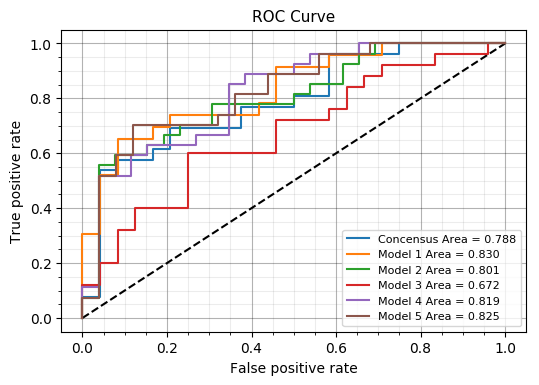

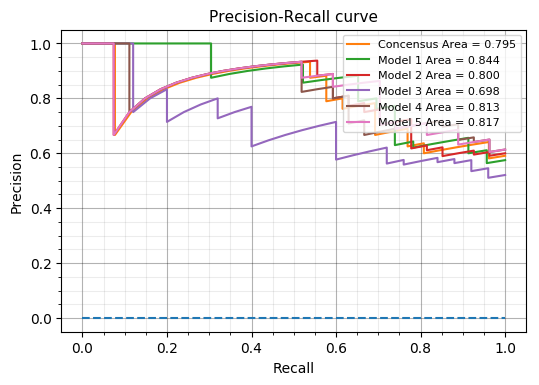




The result of k-fold cross validation step 2 :

Concensus of 5 Models:
Precision of the Model is: 68.18
Recall of the Model is: 71.43
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15         6
True: No           7        15


Model 1 :
Precision of the Model is: 63.33
Recall of the Model is: 79.17
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         19         5
True: No          11        13


Model 2 :
Precision of the Model is: 70.83
Recall of the Model is: 62.96
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         17        10
True: No           7        19


Model 3 :
Precision of the Model is: 70.37
Recall of the Model is: 73.08
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         19         7
True: No           8        17


Model 4 :
Precision of the Model is: 66.67
Recall of the Model is: 61.54
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16        10
True

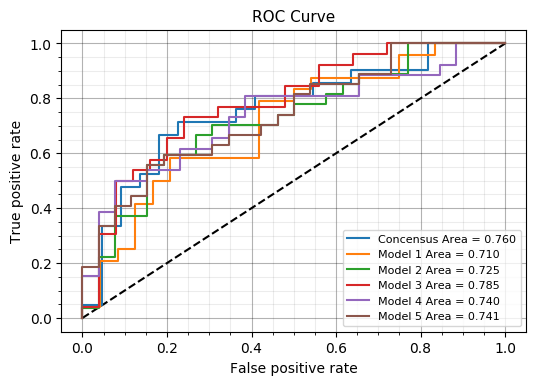

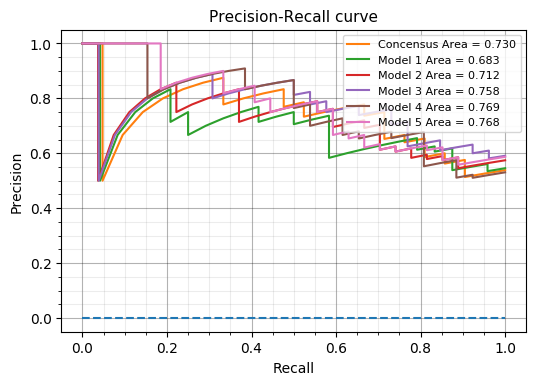




The result of k-fold cross validation step 3 :

Concensus of 5 Models:
Precision of the Model is: 71.43
Recall of the Model is: 71.43
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15         6
True: No           6        18


Model 1 :
Precision of the Model is: 75.00
Recall of the Model is: 72.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         7
True: No           6        19


Model 2 :
Precision of the Model is: 62.50
Recall of the Model is: 57.69
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15        11
True: No           9        17


Model 3 :
Precision of the Model is: 72.73
Recall of the Model is: 69.57
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16         7
True: No           6        17


Model 4 :
Precision of the Model is: 72.73
Recall of the Model is: 61.54
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16        10
True

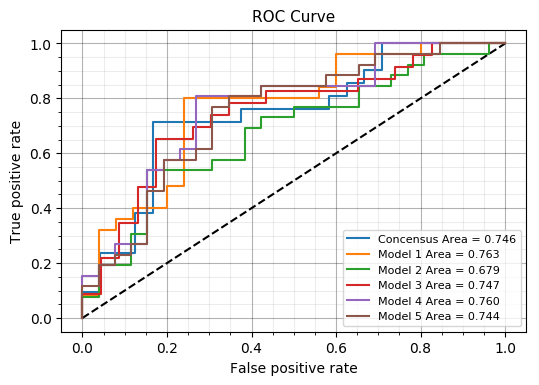

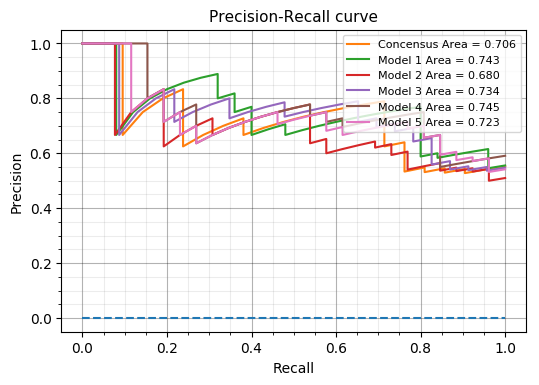




The result of k-fold cross validation step 4 :

Concensus of 5 Models:
Precision of the Model is: 83.33
Recall of the Model is: 78.95
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15         4
True: No           3        20


Model 1 :
Precision of the Model is: 78.57
Recall of the Model is: 91.67
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         22         2
True: No           6        19


Model 2 :
Precision of the Model is: 72.73
Recall of the Model is: 61.54
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16        10
True: No           6        20


Model 3 :
Precision of the Model is: 100.00
Recall of the Model is: 60.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes          6         4
True: No           0        22


Model 4 :
Precision of the Model is: 83.33
Recall of the Model is: 76.92
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         20         6
Tru

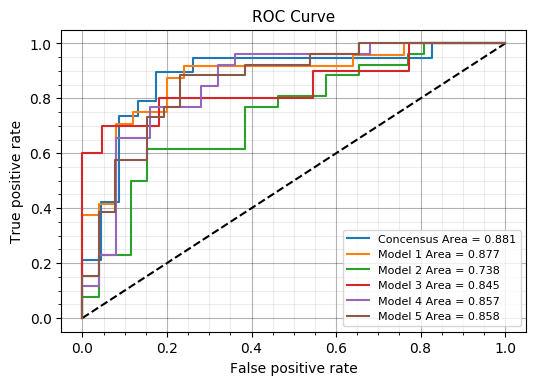

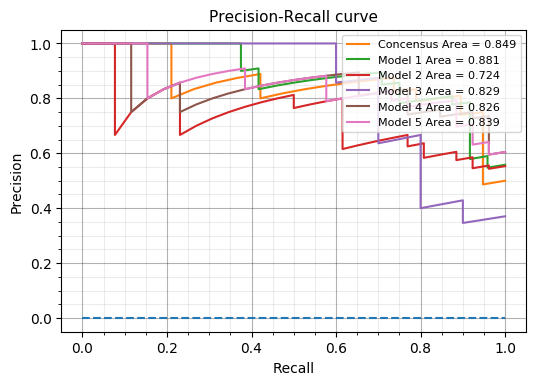




The result of k-fold cross validation step 5 :

Concensus of 5 Models:
Precision of the Model is: 82.35
Recall of the Model is: 63.64
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         14         8
True: No           3        21


Model 1 :
Precision of the Model is: 80.00
Recall of the Model is: 64.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16         9
True: No           4        21


Model 2 :
Precision of the Model is: 68.00
Recall of the Model is: 65.38
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         17         9
True: No           8        18


Model 3 :
Precision of the Model is: 85.71
Recall of the Model is: 69.23
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         8
True: No           3        22


Model 4 :
Precision of the Model is: 76.19
Recall of the Model is: 61.54
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16        10
True

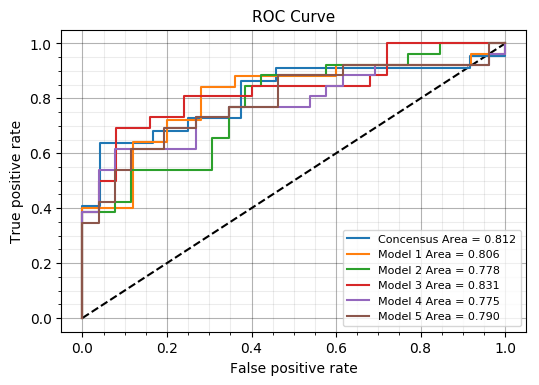

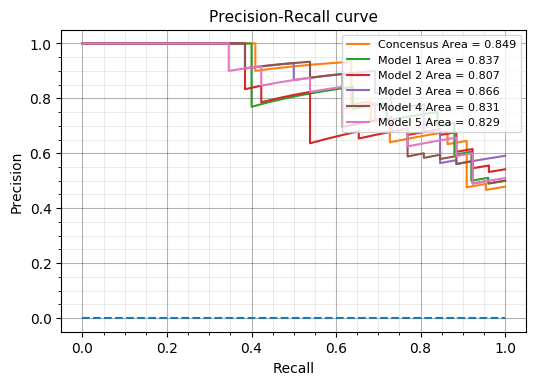




The result of k-fold cross validation step 6 :

Concensus of 5 Models:
Precision of the Model is: 81.25
Recall of the Model is: 65.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         13         7
True: No           3        19


Model 1 :
Precision of the Model is: 77.78
Recall of the Model is: 56.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         14        11
True: No           4        21


Model 2 :
Precision of the Model is: 81.82
Recall of the Model is: 69.23
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         8
True: No           4        21


Model 3 :
Precision of the Model is: 85.71
Recall of the Model is: 100.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         12         0
True: No           2         0


Model 4 :
Precision of the Model is: 78.95
Recall of the Model is: 57.69
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15        11
Tru

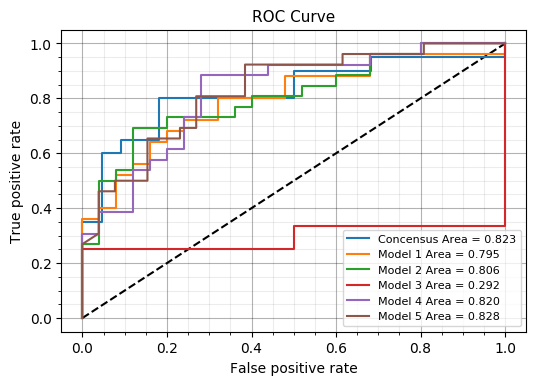

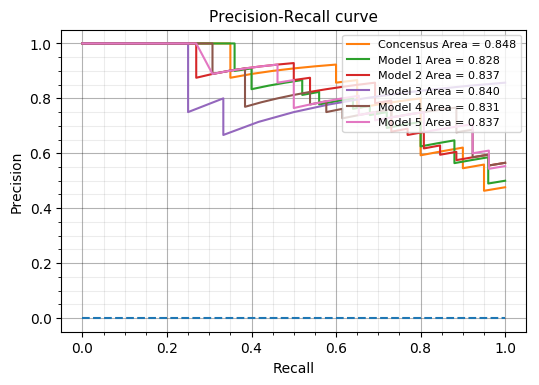




The result of k-fold cross validation step 7 :

Concensus of 5 Models:
Precision of the Model is: 80.00
Recall of the Model is: 76.19
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16         5
True: No           4        15


Model 1 :
Precision of the Model is: 66.67
Recall of the Model is: 78.26
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         5
True: No           9        14


Model 2 :
Precision of the Model is: 65.22
Recall of the Model is: 60.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         15        10
True: No           8        17


Model 3 :
Precision of the Model is: 69.57
Recall of the Model is: 64.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16         9
True: No           7        15


Model 4 :
Precision of the Model is: 68.97
Recall of the Model is: 76.92
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         20         6
True

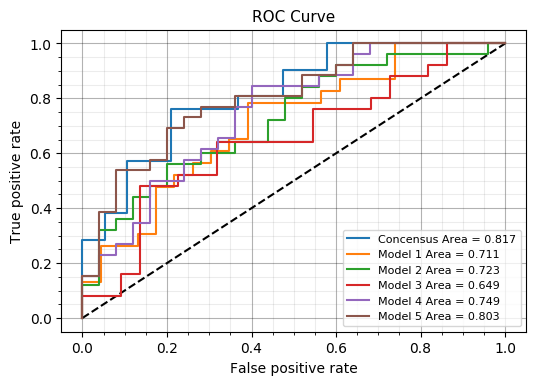

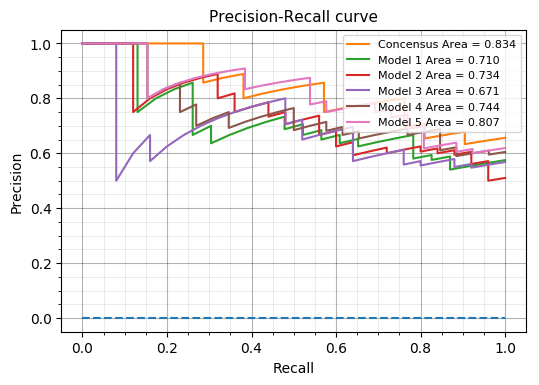




The result of k-fold cross validation step 8 :

Concensus of 5 Models:
Precision of the Model is: 70.83
Recall of the Model is: 73.91
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         17         6
True: No           7        16


Model 1 :
Precision of the Model is: 78.26
Recall of the Model is: 69.23
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         8
True: No           5        18


Model 2 :
Precision of the Model is: 73.08
Recall of the Model is: 73.08
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         19         7
True: No           7        18


Model 3 :
Precision of the Model is: 69.23
Recall of the Model is: 75.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         6
True: No           8        16


Model 4 :
Precision of the Model is: 72.00
Recall of the Model is: 69.23
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         18         8
True

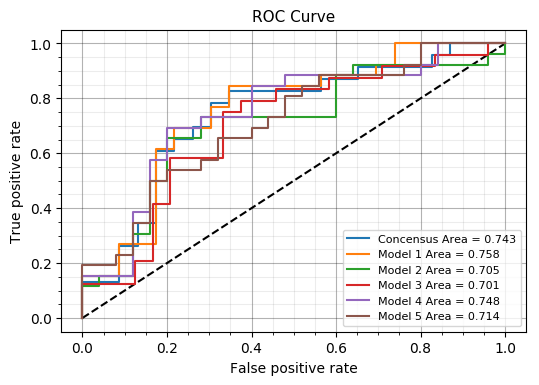

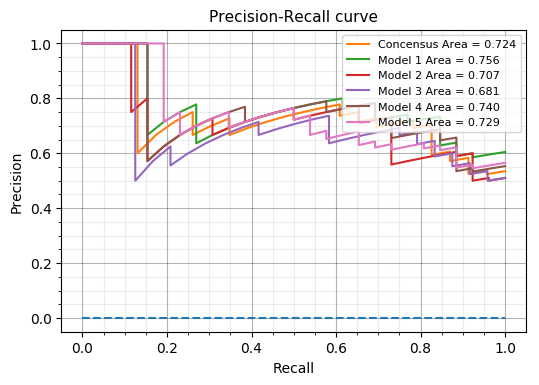




The result of k-fold cross validation step 9 :

Concensus of 5 Models:
Precision of the Model is: 66.67
Recall of the Model is: 63.16
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         12         7
True: No           6        17


Model 1 :
Precision of the Model is: 66.67
Recall of the Model is: 58.33
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         14        10
True: No           7        17


Model 2 :
Precision of the Model is: 64.00
Recall of the Model is: 64.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         16         9
True: No           9        16


Model 3 :
Precision of the Model is: 70.00
Recall of the Model is: 63.64
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         14         8
True: No           6        19


Model 4 :
Precision of the Model is: 61.90
Recall of the Model is: 50.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         13        13
True

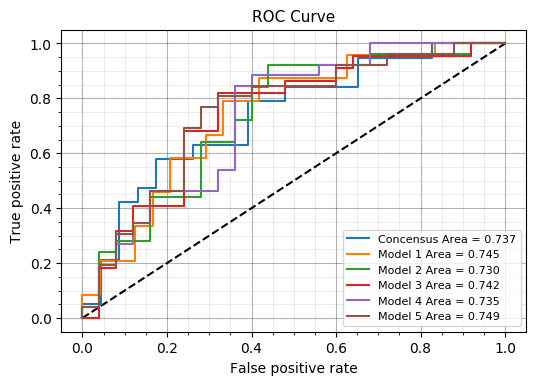

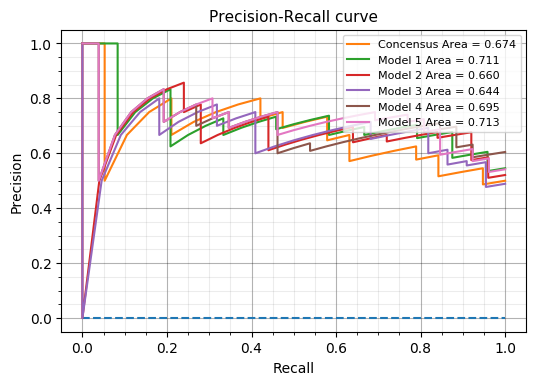




The result of k-fold cross validation step 10 :

Concensus of 5 Models:
Precision of the Model is: 80.00
Recall of the Model is: 96.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         24         1
True: No           6        17


Model 1 :
Precision of the Model is: 78.57
Recall of the Model is: 88.00
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         22         3
True: No           6        17


Model 2 :
Precision of the Model is: 80.00
Recall of the Model is: 92.31
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         24         2
True: No           6        19


Model 3 :
Precision of the Model is: 78.12
Recall of the Model is: 96.15
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         25         1
True: No           7        17


Model 4 :
Precision of the Model is: 75.76
Recall of the Model is: 96.15
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         25         1
Tru

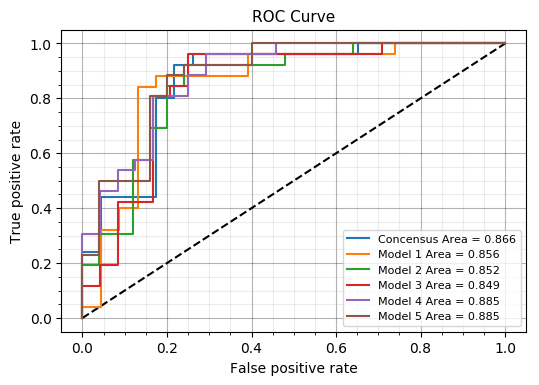

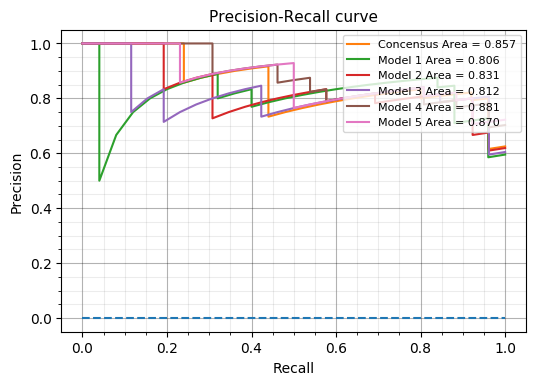

In [120]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from matplotlib.pyplot import figure

pt=0.55
k=4
n=1

print("The best possible selected threshold for pt is %.2f%%"%(pt*100),"\n")
for prediction, y_test in zip(predictionList,y_testList):
    if(n==1):
        print("The result of k-fold cross validation step",n,":\n")
    else:
        print("\n\n\nThe result of k-fold cross validation step",n,":\n")
    prediction1=prediction[0]
    prediction2=prediction[1]
    prediction3=prediction[2]
    prediction4=prediction[3]
    prediction5=prediction[4]
    
    it=0
    
    prediction=[[0],[0],[0],[0],[0],[0]]
    predictionProb=[[0],[0],[0],[0],[0],[0]]
    
    accuracy=[[0],[0],[0],[0],[0],[0]]
    percent=[[0],[0],[0],[0],[0],[0]]


    for p1,p2,p3,p4,p5 in zip(prediction1,prediction2,prediction3,prediction4,prediction5):

        zeroProb=[p1[0],p2[0],p3[0],p4[0],p5[0]]
        oneProb=[p1[1],p2[1],p3[1],p4[1],p5[1]]
        zeroProb.sort(reverse=True)
        oneProb.sort(reverse=True)

        if(zeroProb[k-1]>oneProb[k-1]):
            if(zeroProb[k-1]>pt):
                prediction[0].append([it,0])
                predictionProb[0].append(np.average(oneProb[:k-1]))
        else:
            if(oneProb[k-1]>pt):
                prediction[0].append([it,1])
                predictionProb[0].append(np.average(oneProb[:k-1]))

        if(p1[0]>p1[1]):
            if(p1[0]>pt):
                prediction[1].append([it,0])
                predictionProb[1].append(p1[1])
        else:
            if(p1[1]>pt):
                prediction[1].append([it,1])
                predictionProb[1].append(p1[1])

        if(p2[0]>p2[1]):
            if(p2[0]>pt):
                prediction[2].append([it,0])
                predictionProb[2].append(p2[1])
        else:
            if(p2[1]>pt):
                prediction[2].append([it,1])
                predictionProb[2].append(p2[1])

        if(p3[0]>p3[1]):
            if(p3[0]>pt):
                prediction[3].append([it,0])
                predictionProb[3].append(p3[1])
        else:
            if(p3[1]>pt):
                prediction[3].append([it,1])
                predictionProb[3].append(p3[1])

        if(p4[0]>p4[1]):
            if(p4[0]>pt):
                prediction[4].append([it,0])
                predictionProb[4].append(p4[1])
        else:
            if(p4[1]>pt):
                prediction[4].append([it,1])
                predictionProb[4].append(p4[1])

        if(p5[0]>p5[1]):
            if(p5[0]>pt):
                prediction[5].append([it,0])
                predictionProb[5].append(p5[1])
        else:
            if(p5[1]>pt):
                prediction[5].append([it,1])
                predictionProb[5].append(p5[1])

        it+=1

    for i in range(6):
        prediction[i].pop(0)
        predictionProb[i].pop(0)


    precisionList=[]
    recallList=[]
    fprList=[]
    tprList=[]
    aucFTList=[]
    aucPRList=[]
    thresholdsFTList=[]
    thresholdPRList=[]

    for i in range(6):
        correct=0
        incorrect=0
        y_test_new=[]
        y_pred_new=[]
        y_pred_prob_new=[]
        for p,pp in zip(prediction[i],predictionProb[i]):
            y_test_new.append(np.argmax(y_test[p[0]]))
            y_pred_new.append(p[1])
            y_pred_prob_new.append(pp)
            if(p[1]==np.argmax(y_test[p[0]])):
                correct+=1
            else:
                incorrect+=1
        acc=0
        if(correct+incorrect>0):
            acc=(correct/(incorrect+correct))*100
        per=((correct+incorrect)/y_test.shape[0])*100

        accuracy[i].append(acc)
        percent[i].append(per)

        
        
        if(i==0):
            print("Concensus of 5 Models:")
        else:
            print("Model",i,":")
        conf=confusion_matrix(y_test_new,y_pred_new,labels=[1,0])
        print("Precision of the Model is: %.2f"% ((conf[0][0]/(conf[0][0]+conf[1][0]))*100))
        print("Recall of the Model is: %.2f"% ((conf[0][0]/(conf[0][0]+conf[0][1]))*100))
        print("The confusion Matrix is:")
        print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))
        print("\n")

        fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_prob_new)
        auc_model=auc(fpr,tpr)

        fprList.append(fpr)
        tprList.append(tpr)
        thresholdsFTList.append(thresholds)
        aucFTList.append(auc_model)


        precision, recall, thresholds = precision_recall_curve(y_test_new, y_pred_prob_new)
        auc_model=auc(recall,precision)

        precisionList.append(precision)
        recallList.append(recall)
        thresholdPRList.append(thresholds)
        aucPRList.append(auc_model)


    print("\nAccuracy of Concensus of 5 Models is %.2f"%accuracy[0][1]," for %.2f"%percent[0][1],"% of data")
    accuracy[0].pop(0)
    percent[0].pop(0)
    for i in range(1,6):
        accuracy[i].pop(0)
        percent[i].pop(0)
        print("Accuracy of the Model",i," is %.2f"%accuracy[i][0]," for %.2f"%percent[i][0],"% of data")

    figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.plot(fprList[0],tprList[0],label='Concensus Area = {:.3f}'.format(aucFTList[0]))
    plt.plot(fprList[1],tprList[1],label='Model 1 Area = {:.3f}'.format(aucFTList[1]))
    plt.plot(fprList[2],tprList[2],label='Model 2 Area = {:.3f}'.format(aucFTList[2]))
    plt.plot(fprList[3],tprList[3],label='Model 3 Area = {:.3f}'.format(aucFTList[3]))
    plt.plot(fprList[4],tprList[4],label='Model 4 Area = {:.3f}'.format(aucFTList[4]))
    plt.plot(fprList[5],tprList[5],label='Model 5 Area = {:.3f}'.format(aucFTList[5]))

    plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
    plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
    plt.minorticks_on()
    plt.title('ROC Curve', fontsize=11)
    plt.xlabel('False positive rate', fontsize=10)
    plt.ylabel('True positive rate', fontsize=10)
    plt.legend(loc='lower right', prop={'size': 8})
    plt.show()


    figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.plot([0, 1], [0.0, 0.0], linestyle='--')
    plt.plot(recallList[0],precisionList[0],label='Concensus Area = {:.3f}'.format(aucPRList[0]))
    plt.plot(recallList[1],precisionList[1],label='Model 1 Area = {:.3f}'.format(aucPRList[1]))
    plt.plot(recallList[2],precisionList[2],label='Model 2 Area = {:.3f}'.format(aucPRList[2]))
    plt.plot(recallList[3],precisionList[3],label='Model 3 Area = {:.3f}'.format(aucPRList[3]))
    plt.plot(recallList[4],precisionList[4],label='Model 4 Area = {:.3f}'.format(aucPRList[4]))
    plt.plot(recallList[5],precisionList[5],label='Model 5 Area = {:.3f}'.format(aucPRList[5]))

    plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
    plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
    plt.minorticks_on()
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.title('Precision-Recall curve', fontsize=11)
    plt.legend(loc='upper right', prop={'size': 8})
    plt.show()
    n+=1

In [121]:
cvscores = []

ptList=np.arange(0,1,0.003)
accuracyList=[]
percentList=[]

epochs=125
iteration=1
k=4

scoreList=[]
tempScore=[]

In [122]:
#---------------MODEL -1-----------------------#

from keras.callbacks import EarlyStopping,ModelCheckpoint

K.clear_session()

model1=Sequential()
model1.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                             kernel_initializer='lecun_normal')))
model1.add(MaxPooling1D(2))
model1.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='lecun_normal',
                              kernel_regularizer=regularizers.l2(0.01))))
model1.add(MaxPooling1D(2))
model1.add((LocallyConnected1D(4, 4,activation='selu',kernel_initializer='lecun_normal'
                              ,kernel_regularizer=regularizers.l2(0.01))))
model1.add(MaxPooling1D(2))

model1.add(Flatten())
model1.add(Dense(128,activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.2))
model1.add(Dense(64,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.2))
model1.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform'))
model1.add(Dropout(0.2))
model1.add(Dense(16,activation='selu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.2))
model1.add(Dense(8,activation='relu',kernel_initializer='glorot_uniform'))
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model1.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.00001),metrics=['accuracy'])

model1.summary()

es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
history1 = model1.fit(x_train, y_train, batch_size=32, epochs=150, validation_data=(x_test, y_test),callbacks=[es1])
 
model1.save("Model 1(Ultimate)"+".h5")
print("Model 1 trained")

predict1 = model1.predict(x_test)
scores = model1.evaluate(x_test, y_test)

print("Accuracy of the Model 1"+" is: %.2f%% " % (scores[1]*100))

conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict1,axis=1),labels=[1,0])
print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
print("The confusion Matrix is:\n")
print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

tempScore.append(scores[1]*100)

K.clear_session()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 17, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 68)                0         
__________

In [124]:
#---------------MODEL-2-----------------------#

K.clear_session()
from keras.callbacks import EarlyStopping,ModelCheckpoint

model2=Sequential()
model2.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                             kernel_initializer='lecun_normal')))
model2.add(MaxPooling1D(2))
model2.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='lecun_normal',
                              kernel_regularizer=regularizers.l2(0.01))))
model2.add(MaxPooling1D(2))
model2.add((LocallyConnected1D(4, 4,activation='selu',kernel_initializer='lecun_normal'
                              ,kernel_regularizer=regularizers.l2(0.01))))
model2.add(MaxPooling1D(2))

model2.add(Flatten())
model2.add(Dense(128,activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(64,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(16,activation='selu',kernel_initializer='lecun_uniform',
                 kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(8,activation='relu',kernel_initializer='glorot_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))


model2.compile(loss='categorical_hinge', optimizer=Nadam(lr=0.00001),metrics=['accuracy'])

#model2.summary()

es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history2 = model2.fit(x_train, y_train, batch_size=32, epochs=150,
                      validation_data=(x_test, y_test),callbacks=[es2],verbose=0)

model2.save("Model 2(Ultimate).h5")

print("Model 2 trained")

predict2 = model2.predict(x_test)
scores = model2.evaluate(x_test, y_test)

print("Accuracy of the Model 2 is: %.2f%% " % (scores[1]*100))

conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict2,axis=1),labels=[1,0])
print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
print("The confusion Matrix is:\n")
print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

tempScore.append(scores[1]*100)

K.clear_session()


Epoch 00106: early stopping
Model 2 trained
51/51 [==============================] - 0s 147us/step
Accuracy of the Model 2 is: 80.39% 
Precision of the Model is: 0.75
Recall of the Model is: 0.92 

The confusion Matrix is:

           Pred: Yes  Pred: No
True: Yes         24         2
True: No           8        17


In [125]:
#---------------MODEL-3-----------------------#

K.clear_session()

from keras.callbacks import EarlyStopping,ModelCheckpoint
model3=Sequential()
model3.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                             kernel_initializer='lecun_normal')))
model3.add(MaxPooling1D(2))
model3.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                              kernel_regularizer=regularizers.l2(0.01))))
model3.add(MaxPooling1D(2))
model3.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='lecun_normal'
                              ,kernel_regularizer=regularizers.l2(0.01))))
model3.add(MaxPooling1D(2))

model3.add(Flatten())


model3.add(Dense(128,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(32,activation='elu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(16,activation='tanh',kernel_initializer='he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(8,activation='relu',kernel_initializer='lecun_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(4,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(2, activation='softmax',kernel_initializer='glorot_normal'))

model3.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.00001),metrics=['accuracy'])
model3.summary()

es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
history3 = model3.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test),callbacks=[es3])
 
model3.save("Model 3(Ultimate)"+".h5")
print("Model 3 trained")

predict3 = model3.predict(x_test)
scores = model3.evaluate(x_test, y_test)

print("Accuracy of the Model 3"+" is: %.2f%% " % (scores[1]*100))

conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict3,axis=1),labels=[1,0])
print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
print("The confusion Matrix is:\n")
print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

tempScore.append(scores[1]*100)

K.clear_session()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 17, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 68)                0         
__________

4000/4000 [==============================] - 2s 377us/step - loss: 1.4543 - acc: 0.6863 - val_loss: 1.4129 - val_acc: 0.8431
Epoch 98/200
4000/4000 [==============================] - 2s 454us/step - loss: 1.4386 - acc: 0.6895 - val_loss: 1.3996 - val_acc: 0.8627
Epoch 99/200
4000/4000 [==============================] - 1s 361us/step - loss: 1.4324 - acc: 0.6823 - val_loss: 1.3876 - val_acc: 0.8431
Epoch 100/200
4000/4000 [==============================] - 1s 364us/step - loss: 1.4146 - acc: 0.6868 - val_loss: 1.3764 - val_acc: 0.8235
Epoch 101/200
4000/4000 [==============================] - 1s 364us/step - loss: 1.4035 - acc: 0.6787 - val_loss: 1.3630 - val_acc: 0.8431
Epoch 102/200
4000/4000 [==============================] - 2s 443us/step - loss: 1.3926 - acc: 0.6803 - val_loss: 1.3522 - val_acc: 0.8235
Epoch 103/200
4000/4000 [==============================] - 1s 360us/step - loss: 1.3812 - acc: 0.6835 - val_loss: 1.3403 - val_acc: 0.8431
Epoch 104/200
4000/4000 [==================

In [126]:
#---------------MODEL-4-----------------------#

K.clear_session()

from keras.callbacks import EarlyStopping,ModelCheckpoint
model4=Sequential()
model4.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                             kernel_initializer='he_normal')))
model4.add(MaxPooling1D(2))
model4.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                              kernel_regularizer=regularizers.l2(0.01))))
model4.add(MaxPooling1D(2))
model4.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='he_normal'
                              ,kernel_regularizer=regularizers.l2(0.01))))
model4.add(MaxPooling1D(4))

model4.add(Flatten())


model4.add(Dense(128,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
model4.add(Dropout(0.2))
model4.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))

model4.add(Dense(16,activation='tanh',kernel_initializer='lecun_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(8,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))
model4.add(Dropout(0.2))

model4.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model4.compile(loss='categorical_hinge', optimizer=Adam(lr=0.000015),metrics=['accuracy'])
model4.summary()

es4 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
history4 = model4.fit(x_train, y_train, batch_size=32, epochs=150, validation_data=(x_test, y_test),callbacks=[es4])
 
model4.save("Model 4(Ultimate)"+".h5")
print("Model 4 trained")

predict4 = model4.predict(x_test)
scores = model4.evaluate(x_test, y_test)

print("Accuracy of the Model 2"+" is: %.2f%% " % (scores[1]*100))

conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict4,axis=1),labels=[1,0])
print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
print("The confusion Matrix is:\n")
print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

tempScore.append(scores[1]*100)

K.clear_session()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
__________

In [127]:
#---------------MODEL-5-----------------------#

K.clear_session()

from keras.callbacks import EarlyStopping,ModelCheckpoint
model5=Sequential()
model5.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                             kernel_initializer='he_normal')))
model5.add(MaxPooling1D(2))
model5.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                              kernel_regularizer=regularizers.l2(0.01))))
model5.add(MaxPooling1D(2))
model5.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='he_normal'
                              ,kernel_regularizer=regularizers.l2(0.01))))
model5.add(MaxPooling1D(2))

model5.add(Flatten())


model5.add(Dense(128,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dropout(0.2))
model5.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model5.add(Dropout(0.2))
model5.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))

model5.add(Dense(16,activation='elu',kernel_initializer='lecun_uniform'))
model5.add(Dropout(0.2))
model5.add(Dense(8,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dropout(0.2))

model5.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

model5.compile(loss='categorical_hinge', optimizer=Adam(lr=0.000015),metrics=['accuracy'])

model5.summary()

es5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
history2 = model5.fit(x_train, y_train, batch_size=32, epochs=150, validation_data=(x_test, y_test),callbacks=[es5])
 
model5.save("Model 5(Ultimate)"+".h5")
print("Model 5 trained")

predict5 = model5.predict(x_test)
scores = model5.evaluate(x_test, y_test)

print("Accuracy of the Model 2"+" is: %.2f%% " % (scores[1]*100))

conf=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predict5,axis=1),labels=[1,0])
print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
print("Recall of the Model is: %.2f \n"% (conf[0][0]/(conf[0][0]+conf[0][1])))
print("The confusion Matrix is:\n")
print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))

tempScore.append(scores[1]*100)

K.clear_session()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 17, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 68)                0         
__________

---------------------------------------------CONCENSUS MODEL-------------------------------------------

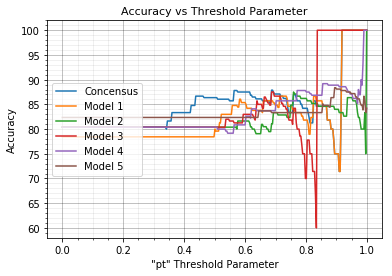

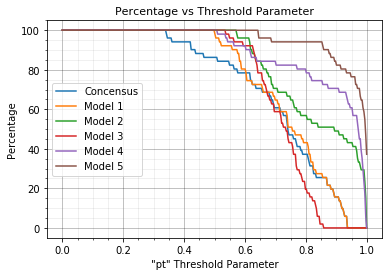

In [128]:
accuracy=[[0],[0],[0],[0],[0],[0]]
percent=[[0],[0],[0],[0],[0],[0]]

for pt in ptList:


    it=0
    predictionListofDict = [dict() for x in range(6)]


    naminglist=['Concensus','Model1','Model2','Model3','Model4','Model5']

    for iteration,names in zip(predictionListofDict,naminglist):
        iteration[names] = [{'0':[]},{'1':[]}]

    #print(predictionListofDict)

    for p1,p2,p3,p4,p5 in zip(predict1,predict2,predict3,predict4,predict5):

        zeroProb = [p1[0],p2[0],p3[0],p4[0],p5[0]]
        oneProb = [p1[1],p2[1],p3[1],p4[1],p5[1]]

        zeroProb.sort(reverse=True)
        oneProb.sort(reverse=True)

        if(zeroProb[k-1]>oneProb[k-1]):
            if(zeroProb[k-1]>pt):
                predictionListofDict[0]['Concensus'][0]['0'].append(it)

        else:
            if(oneProb[k-1]>pt):
                predictionListofDict[0]['Concensus'][1]['1'].append(it)


        if(p1[0]>p1[1]):
            if(p1[0]>pt):
                predictionListofDict[1]['Model1'][0]['0'].append(it)
        else:
            if(p1[1]>pt):
                predictionListofDict[1]['Model1'][1]['1'].append(it)

        if(p2[0]>p2[1]):
            if(p2[0]>pt):
                predictionListofDict[2]['Model2'][0]['0'].append(it)
        else:
            if(p2[1]>pt):
                predictionListofDict[2]['Model2'][1]['1'].append(it)

        if(p3[0]>p3[1]):
            if(p3[0]>pt):
                predictionListofDict[3]['Model3'][0]['0'].append(it)
        else:
            if(p3[1]>pt):
                predictionListofDict[3]['Model3'][1]['1'].append(it)

        if(p4[0]>p4[1]):
            if(p4[0]>pt):
                predictionListofDict[4]['Model4'][0]['0'].append(it)
        else:
            if(p4[1]>pt):
                predictionListofDict[4]['Model4'][1]['1'].append(it)

        if(p5[0]>p5[1]):
            if(p5[0]>pt):
                predictionListofDict[5]['Model5'][0]['0'].append(it)
        else:
            if(p5[1]>pt):
                predictionListofDict[5]['Model5'][1]['1'].append(it)

        it+=1


    correct=0
    incorrect=0

    for values in predictionListofDict[0]['Concensus'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[0]['Concensus'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1 

    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)

    accuracy[0].append(acc)
    percent[0].append(per)
    
    correct=0
    incorrect=0
    for values in predictionListofDict[1]['Model1'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[1]['Model1'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1

    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)


    accuracy[1].append(acc)
    percent[1].append(per)
    
    
    correct=0
    incorrect=0
    for values in predictionListofDict[2]['Model2'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[2]['Model2'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1

    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)

    
    accuracy[2].append(acc)
    percent[2].append(per)
    
    correct=0
    incorrect=0


    for values in predictionListofDict[3]['Model3'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[3]['Model3'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1

    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)


    accuracy[3].append(acc)
    percent[3].append(per)
    
    
    correct=0
    incorrect=0

    for values in predictionListofDict[4]['Model4'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[4]['Model4'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1


    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)


    accuracy[4].append(acc)
    percent[4].append(per)
    
    correct=0
    incorrect=0
    for values in predictionListofDict[5]['Model5'][0]['0']:
        if np.argmax(y_test[values]) ==0:
            correct = correct+1
        else:
            incorrect = incorrect+1

    for values in predictionListofDict[5]['Model5'][1]['1']:
        if np.argmax(y_test[values]) ==1:
            correct = correct+1
        else:
            incorrect = incorrect+1


    acc=100
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100
    #print(acc,per)
    
    
    
    accuracy[5].append(acc)
    percent[5].append(per)
    
for i in range(6):
    accuracy[i].pop(0)
    percent[i].pop(0)

#figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(ptList,accuracy[0])
plt.plot(ptList,accuracy[1])
plt.plot(ptList,accuracy[2])
plt.plot(ptList,accuracy[3])
plt.plot(ptList,accuracy[4])
plt.plot(ptList,accuracy[5])

plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
plt.minorticks_on()
plt.title('Accuracy vs Threshold Parameter',fontsize=11)
plt.ylabel('Accuracy',fontsize=10)
plt.xlabel('"pt" Threshold Parameter',fontsize=10)
plt.legend(['Concensus', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='center left')
plt.savefig('accuracyPlot.png',prop={'size': 8})
plt.show()

#figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(ptList,percent[0])
plt.plot(ptList,percent[1])
plt.plot(ptList,percent[2])
plt.plot(ptList,percent[3])
plt.plot(ptList,percent[4])
plt.plot(ptList,percent[5])

plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
plt.minorticks_on()
plt.title('Percentage vs Threshold Parameter',fontsize=11)
plt.ylabel('Percentage',fontsize=10)
plt.xlabel('"pt" Threshold Parameter',fontsize=10)
plt.legend(['Concensus', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='center left')
plt.savefig('percentPlot.png',prop={'size': 8})
plt.show()

Concensus of 5 Models:
Precision of the Model is: 0.80
Recall of the Model is: 0.96
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         24         1
True: No           6        17


Model 1 :
Precision of the Model is: 0.79
Recall of the Model is: 0.88
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         22         3
True: No           6        17


Model 2 :
Precision of the Model is: 0.80
Recall of the Model is: 0.92
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         24         2
True: No           6        19


Model 3 :
Precision of the Model is: 0.78
Recall of the Model is: 0.96
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         25         1
True: No           7        17


Model 4 :
Precision of the Model is: 0.76
Recall of the Model is: 0.96
The confusion Matrix is:
           Pred: Yes  Pred: No
True: Yes         25         1
True: No           8        16


Model 5 :
Precision of the Model

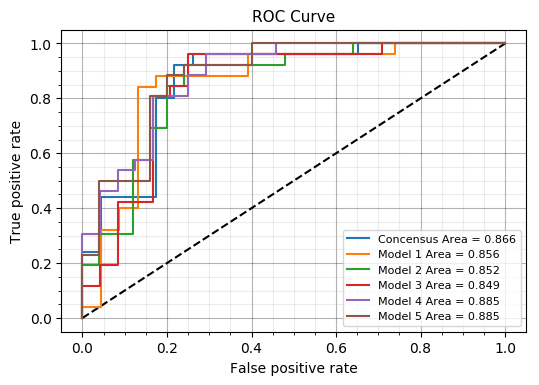

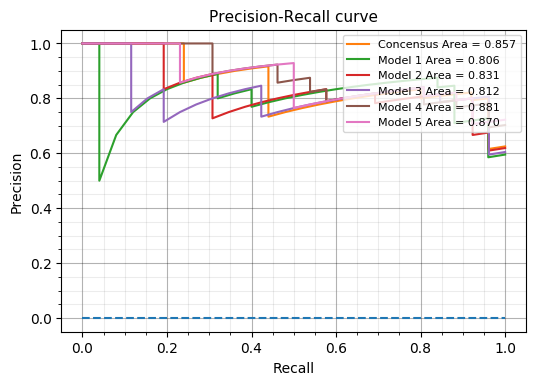

In [129]:
accuracy=[[0],[0],[0],[0],[0],[0]]
percent=[[0],[0],[0],[0],[0],[0]]


pt=0.55
it=0
k=4
prediction=[[0],[0],[0],[0],[0],[0]]
predictionProb=[[0],[0],[0],[0],[0],[0]]


for p1,p2,p3,p4,p5 in zip(prediction1,prediction2,prediction3,prediction4,prediction5):

    zeroProb=[p1[0],p2[0],p3[0],p4[0],p5[0]]
    oneProb=[p1[1],p2[1],p3[1],p4[1],p5[1]]
    zeroProb.sort(reverse=True)
    oneProb.sort(reverse=True)

    if(zeroProb[k-1]>oneProb[k-1]):
        if(zeroProb[k-1]>pt):
            prediction[0].append([it,0])
            predictionProb[0].append(np.average(oneProb[:k-1]))
    else:
        if(oneProb[k-1]>pt):
            prediction[0].append([it,1])
            predictionProb[0].append(np.average(oneProb[:k-1]))

    if(p1[0]>p1[1]):
        if(p1[0]>pt):
            prediction[1].append([it,0])
            predictionProb[1].append(p1[1])
    else:
        if(p1[1]>pt):
            prediction[1].append([it,1])
            predictionProb[1].append(p1[1])

    if(p2[0]>p2[1]):
        if(p2[0]>pt):
            prediction[2].append([it,0])
            predictionProb[2].append(p2[1])
    else:
        if(p2[1]>pt):
            prediction[2].append([it,1])
            predictionProb[2].append(p2[1])

    if(p3[0]>p3[1]):
        if(p3[0]>pt):
            prediction[3].append([it,0])
            predictionProb[3].append(p3[1])
    else:
        if(p3[1]>pt):
            prediction[3].append([it,1])
            predictionProb[3].append(p3[1])

    if(p4[0]>p4[1]):
        if(p4[0]>pt):
            prediction[4].append([it,0])
            predictionProb[4].append(p4[1])
    else:
        if(p4[1]>pt):
            prediction[4].append([it,1])
            predictionProb[4].append(p4[1])

    if(p5[0]>p5[1]):
        if(p5[0]>pt):
            prediction[5].append([it,0])
            predictionProb[5].append(p5[1])
    else:
        if(p5[1]>pt):
            prediction[5].append([it,1])
            predictionProb[5].append(p5[1])

    it+=1

for i in range(6):
    prediction[i].pop(0)
    predictionProb[i].pop(0)
    
    
precisionList=[]
recallList=[]
fprList=[]
tprList=[]
aucFTList=[]
aucPRList=[]
thresholdsFTList=[]
thresholdPRList=[]

for i in range(6):
    correct=0
    incorrect=0
    y_test_new=[]
    y_pred_new=[]
    y_pred_prob_new=[]
    for p,pp in zip(prediction[i],predictionProb[i]):
        y_test_new.append(np.argmax(y_test[p[0]]))
        y_pred_new.append(p[1])
        y_pred_prob_new.append(pp)
        if(p[1]==np.argmax(y_test[p[0]])):
            correct+=1
        else:
            incorrect+=1
    acc=0
    if(correct+incorrect>0):
        acc=(correct/(incorrect+correct))*100
    per=((correct+incorrect)/y_test.shape[0])*100

    accuracy[i].append(acc)
    percent[i].append(per)
    
    
    if(i==0):
        print("Concensus of 5 Models:")
    else:
        print("Model",i,":")
    conf=confusion_matrix(y_test_new,y_pred_new,labels=[1,0])
    print("Precision of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[1][0])))
    print("Recall of the Model is: %.2f"% (conf[0][0]/(conf[0][0]+conf[0][1])))
    print("The confusion Matrix is:")
    print(pd.DataFrame(conf,index=['True: Yes', 'True: No'], columns=['Pred: Yes', 'Pred: No']))
    print("\n")
    
    fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_prob_new)
    auc_model=auc(fpr,tpr)
    
    fprList.append(fpr)
    tprList.append(tpr)
    thresholdsFTList.append(thresholds)
    aucFTList.append(auc_model)
    
    
    precision, recall, thresholds = precision_recall_curve(y_test_new, y_pred_prob_new)
    auc_model=auc(recall,precision)
    
    precisionList.append(precision)
    recallList.append(recall)
    thresholdPRList.append(thresholds)
    aucPRList.append(auc_model)


print("\n\n\nAccuracy of Concensus of 5 Models is %.2f"%accuracy[0][1]," for %.2f"%percent[0][1],"% of data")
accuracy[0].pop(0)
percent[0].pop(0)
for i in range(1,6):
    accuracy[i].pop(0)
    percent[i].pop(0)
    print("Accuracy of the Model",i," is %.2f"%accuracy[i][0]," for %.2f"%percent[i][0],"% of data")
    
figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')    
plt.plot(fprList[0],tprList[0],label='Concensus Area = {:.3f}'.format(aucFTList[0]))
plt.plot(fprList[1],tprList[1],label='Model 1 Area = {:.3f}'.format(aucFTList[1]))
plt.plot(fprList[2],tprList[2],label='Model 2 Area = {:.3f}'.format(aucFTList[2]))
plt.plot(fprList[3],tprList[3],label='Model 3 Area = {:.3f}'.format(aucFTList[3]))
plt.plot(fprList[4],tprList[4],label='Model 4 Area = {:.3f}'.format(aucFTList[4]))
plt.plot(fprList[5],tprList[5],label='Model 5 Area = {:.3f}'.format(aucFTList[5]))

plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
plt.minorticks_on()
plt.title('ROC Curve', fontsize=11)
plt.xlabel('False positive rate', fontsize=10)
plt.ylabel('True positive rate', fontsize=10)
plt.legend(loc='lower right', prop={'size': 8})
plt.show()


figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0.0, 0.0], linestyle='--')
plt.plot(recallList[0],precisionList[0],label='Concensus Area = {:.3f}'.format(aucPRList[0]))
plt.plot(recallList[1],precisionList[1],label='Model 1 Area = {:.3f}'.format(aucPRList[1]))
plt.plot(recallList[2],precisionList[2],label='Model 2 Area = {:.3f}'.format(aucPRList[2]))
plt.plot(recallList[3],precisionList[3],label='Model 3 Area = {:.3f}'.format(aucPRList[3]))
plt.plot(recallList[4],precisionList[4],label='Model 4 Area = {:.3f}'.format(aucPRList[4]))
plt.plot(recallList[5],precisionList[5],label='Model 5 Area = {:.3f}'.format(aucPRList[5]))

plt.grid(b=True, which='major', color='black', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='gray', linestyle='-',alpha=0.15)
plt.minorticks_on()
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.title('Precision-Recall curve', fontsize=11)
plt.legend(loc='upper right', prop={'size': 8})
plt.show()